## tool.py  用于回测 以及 因子有效性的测试

#### 因子有效性检验框架
考虑到可能存在的情形是，当天发出买卖信号持有至收盘，
计算IC为分钟信号与分钟收盘价到当日收盘价收益的相关系数
只考虑量价因子

In [2]:
from main import *

In [2]:
ETF_minquotes = pd.read_parquet(f'ETF_minquotes.parquet')
F588080 = ETF_minquotes.loc[ETF_minquotes['windcode'] == '588080.SH']

In [3]:
stop_loss_ratio = 0.02  # 2%止损比例
periods = [('09:59','10:59'),('13:29','14:29')]  # 信号生成时间段
rolling_rank = True  # 是否使用滚动排序作为分位数的计算方式
rolling_window = 240  # 滚动排序窗口大小
upper_bound = 0.8  # 分位数上界
lower_bound = 0.2  # 分位数下界
stop_bound = 0.5  # 止损分位数
factor_name = 'close'

In [4]:
data = F588080.copy()
data['%H:%M'] = data.index.strftime('%H:%M')

In [77]:
data[f'{factor_name}_upper_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(upper_bound)
data[f'{factor_name}_lower_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(lower_bound)
data[f'{factor_name}_stop_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(stop_bound)
if not rolling_rank: # 取过去几日的分位数固定当日的上下界
    data[f'{factor_name}_upper_bound'].shift().groupby(data[f'{factor_name}_upper_bound'].index.date).transform(lambda x: x.iloc[0])  
    data[f'{factor_name}_lower_bound'].shift().groupby(data[f'{factor_name}_lower_bound'].index.date).transform(lambda x: x.iloc[0])
    data[f'{factor_name}_stop_bound'].shift().groupby(data[f'{factor_name}_stop_bound'].index.date).transform(lambda x: x.iloc[0])


In [78]:
data['signal'] = 0
data.loc[data[factor_name] > data[f'{factor_name}_upper_bound'], 'signal'] = 1    # 买入信号
data.loc[data[factor_name] < data[f'{factor_name}_lower_bound'], 'signal'] = -1   # 卖出信号

# 创建一个布尔掩码，初始值都为 False
mask = pd.Series(False, index=data.index)
# 遍历每个时间段
for start_time, end_time in periods:    # 为每个时间段内的时间点设置掩码为 True
    mask = mask | ((data.loc[:,'%H:%M'] >= start_time) & (data.loc[:,'%H:%M']  <= end_time))
data.loc[~mask, 'signal'] = 0

In [9]:
temp = data[240:480]

In [5]:
def get_position(temp):
    OpenTime = temp.loc[temp['signal']!=0,'signal']
    OpenTime = OpenTime.idxmin() if len(OpenTime) != 0 else temp['signal'].idxmin()# 开仓时刻（下一时刻的open价买入）
    direction = temp.loc[OpenTime,'signal'] #确定一开始的买入卖出方向 1表示买入，-1表示卖出

    temp.loc[:,'Openpos'] = (temp.index>OpenTime)  # 判断是否已开仓
    temp.loc[:,'Openprice'] = temp.loc[temp['Openpos'],'open'].iloc[0]  # 记录开仓价格
    temp.loc[:,'Holdret'] = temp['close']/temp['Openprice']-1  # 计算持仓收益
    temp.loc[:,'Stoploss'] = temp['Holdret']>-stop_loss_ratio  # 判断是否触发收益止损比例
    if direction == 1:  #这里还需要乘上有效时间段
        temp.loc[:,'Stopsignal'] = temp[factor_name] >= temp[f'{factor_name}_upper_stop_bound']  # 判断是否触发信号止损分位数
    elif direction == -1:
        temp.loc[:,'Stopsignal'] = temp[factor_name] <= temp[f'{factor_name}_lower_stop_bound']  # 判断是否触发信号止损分位数
    else:
        temp.loc[:,'Stopsignal'] = False
    mask = pd.Series(False, index=temp.index)
    for start_time, end_time in periods:    # 为每个时间段内的时间点设置掩码为 True
        mask = mask | ((temp.loc[:,'%H:%M'] >= start_time) & (temp.loc[:,'%H:%M']  <= end_time))
    temp.loc[~mask, 'Stopsignal'] = True       # 将不在时间段内的信号设置为0
    
    temp.loc[:,'position'] = direction*temp['Openpos'] * temp['Stoploss'] * temp['Stopsignal']  # 计算持仓信号

    CloseTime = temp.loc[(temp['position']==0)&(temp['position'].shift()==direction),'position']  # 记录平仓时刻
    if len(CloseTime) != 0:
        CloseTime = CloseTime.idxmin()  # 显示平仓时刻
        temp.loc[CloseTime,'position'] = direction  # 平仓时刻后持仓信号为0
        temp.loc[temp.index>CloseTime,'position'] = 0
    return temp

In [11]:
data = FactorIC_.minquotes['F588080']
factor_name = 'ADL_4hour'
data['%H:%M'] = data.index.strftime('%H:%M')
upper_stop_bound = 0.5
lower_stop_bound = 0.5
rolling_window = 480
upper_bound = 0.8
lower_bound = 0.2
stop_loss_ratio = 0.02
periods = [('12:59','14:55')]
data[f'{factor_name}_upper_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(upper_bound)
data[f'{factor_name}_lower_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(lower_bound)
data[f'{factor_name}_upper_stop_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(upper_stop_bound)
data[f'{factor_name}_lower_stop_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(lower_stop_bound)

data['signal'] = 0
data.loc[data[factor_name] > data[f'{factor_name}_upper_bound'], 'signal'] = 1    # 买入信号
data.loc[data[factor_name] < data[f'{factor_name}_lower_bound'], 'signal'] = -1   # 卖出信号

# 创建一个布尔掩码，初始值都为 False
mask = pd.Series(False, index=data.index)
for start_time, end_time in periods:    # 为每个时间段内的时间点设置掩码为 True
    mask = mask | ((data.loc[:,'%H:%M'] >= start_time) & (data.loc[:,'%H:%M']  <= end_time))
data.loc[~mask, 'signal'] = 0       # 将不在时间段内的信号设置为0
data = data.groupby(data.index.date).apply(get_position).droplevel(0)  # 每日只保留第一个信号


In [7]:
for d in np.unique(data.index.date):
    temp = data.loc[data.index.date==d]
    get_position(temp)

IndexError: single positional indexer is out-of-bounds

In [8]:
OpenTime

Timestamp('2023-01-13 14:59:00')

In [10]:
temp.loc[temp['signal']!=0,'signal']

2023-02-07 14:59:00   -1
Name: signal, dtype: int64

In [ ]:
OpenTime = temp.loc[temp['signal']!=0,'signal']
OpenTime = OpenTime.idxmin() if len(OpenTime) != 0 else temp['signal'].idxmin()# 开仓时刻（下一时刻的open价买入）
direction = temp.loc[OpenTime,'signal'] #确定一开始的买入卖出方向 1表示买入，-1表示卖出

temp.loc[:,'Openpos'] = (temp.index>OpenTime)  # 判断是否已开仓
temp.loc[:,'Openprice'] = temp.loc[temp['Openpos'],'open'].iloc[0]  # 记录开仓价格
temp.loc[:,'Holdret'] = temp['close']/temp['Openprice']-1  # 计算持仓收益
temp.loc[:,'Stoploss'] = temp['Holdret']>-stop_loss_ratio  # 判断是否触发收益止损比例


IndexError: single positional indexer is out-of-bounds

In [17]:
temp.loc[temp['Openpos'],'open']

Series([], Name: open, dtype: float64)

平均持仓时间: 122.295172 分钟
胜率：0.485477
年化收益率：0.827450
年化夏普比率：4.593506


direction  holdingmins      dailyret
2022-02-14          0            0  0.000000e+00
2022-02-15          1          210  1.476620e-02
2022-02-16          1          120 -8.090615e-04
2022-02-17          1            4 -3.231018e-03
2022-02-18         -1          209 -4.930124e-03
...               ...          ...           ...
2025-02-05          1          128  1.998401e-15
2025-02-06          1          210  2.073050e-02
2025-02-07          1          139  9.578544e-04
2025-02-10          1           90  2.835539e-03
2025-02-11          1           34 -9.425071e-03

[725 rows x 3 columns]

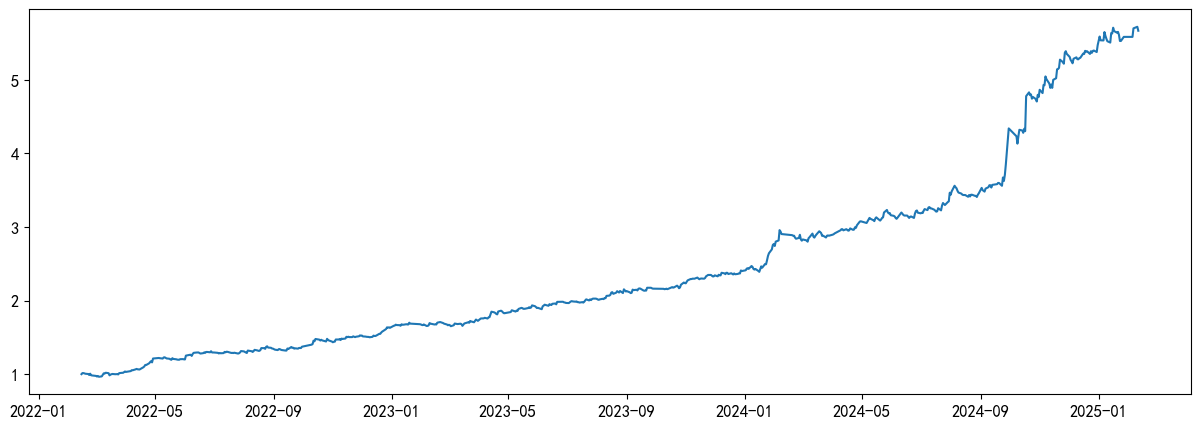

In [ ]:
strategy1 = ETFIntradayStrategy(
    data=data,
    factor_name = factor_name,
    direction = 1,
    periods = [('09:59','10:59'),('13:29','14:29')],
    rolling_rank = True,
    rolling_window = 480,
    upper_bound = 0.8,
    lower_bound = 0.2,
    stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
strategy1.get_performance()

In [ ]:
def generate_position(self):
    """生成持仓（1表示持有多仓，-1表示持有空仓）"""
    # 生成信号
    signals = pd.DataFrame(0, index=data.index, columns=['signal'])
    signals.loc[ data[self.factor_name] > self.BuyBound, 'signal'] = 1    # 买入信号
    signals.loc[self.data[self.factor_name] < self.SellBound, 'signal'] = -1   # 卖出信号
    # 限制开仓时间
    signals.loc[signals.index.strftime('%H:%M') < self.LimitOpenTime] = 0
    signals['pos'] = signals['signal'].groupby(signals.index.date).apply(self.get_position).values
    return signals

def get_position(self,temp):
    """根据信号生成仓位"""
    temp = temp.replace(0,np.nan).ffill().replace(np.nan,0)  # 填充信号
    temp_diff = temp.diff()  # 之后是去找到每天开仓后那一段0的时间段，即为持仓期
    temp_diff.iloc[0] = temp.iloc[0]
    temp_diff = temp_diff.replace(0,np.nan).ffill().replace(np.nan,0)  # 填充信号   目的是保留那些为1或-1的值，其index的下一期则为持仓期
    position = pd.DataFrame(0, index=temp.index, columns=['position'])
    if len(temp_diff[temp_diff.abs()==1])>0:
        position.loc[temp_diff[temp_diff.abs().shift()==1].index] = temp_diff[temp_diff.abs()==1].iloc[0]
    # 可以考虑加一些限制条件，比如不能在最后30分钟开仓
    return position

## 一、连接wind数据库

In [1]:
from utils import *
from main import *
from WindPy import w
w.start()
w.isconnected()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


True

## 二、获取数据并保存至本地
起始日期 2022年2月14日-2025年2月11日

In [132]:
codes = ['588080.SH','159915.SZ']
fields = 'open,high,low,close,volume,amt,chg,pct_chg,'
begin_time = '2022-02-11 09:30:00'
end_time = '2025-02-11 15:00:00'
error, data = w.wsi(codes, fields, begin_time, end_time, "Fill=Previous",usedf=True)  #不复权 
### 剔除11:30和15:00的数据
data = data[(data.index.strftime("%H:%M")!="11:30") & (data.index.strftime("%H:%M")!="15:00")]
data.to_parquet('ETF_minquotes.parquet') 

## 三、因子构造

### 3.1 手动挖掘的信号因子

In [1]:
from utils import *

#### 3.1.1 成交量分布的高阶矩

F159915: volume_ratio: 持有至收盘 IC: 0.022, IR: 0.590
F159915: volume_kurt_10min: 持有至收盘 IC: -0.004, IR: -0.092
F159915: volume_kurt_1hour: 持有至收盘 IC: 0.007, IR: 0.278
F159915: volume_kurt_4hour: 持有至收盘 IC: -0.044, IR: -1.228
F159915: volume_kurt_1hour_4hour: 持有至收盘 IC: 0.021, IR: 0.593
F159915: volume_skew_10min: 持有至收盘 IC: -0.004, IR: -0.111
F159915: volume_skew_1hour: 持有至收盘 IC: 0.010, IR: 0.337
F159915: volume_skew_4hour: 持有至收盘 IC: -0.032, IR: -0.936
F159915: volume_skew_1hour_4hour: 持有至收盘 IC: 0.024, IR: 0.580
F159915: volume_std_10min: 持有至收盘 IC: 0.023, IR: 0.629
F159915: volume_std_1hour: 持有至收盘 IC: 0.049, IR: 1.273
F159915: volume_std_4hour: 持有至收盘 IC: 0.044, IR: 1.561
F159915: volume_std_1hour_4hour: 持有至收盘 IC: 0.030, IR: 0.800
F588080: volume_ratio: 持有至收盘 IC: 0.029, IR: 0.874
F588080: volume_kurt_10min: 持有至收盘 IC: 0.000, IR: 0.009
F588080: volume_kurt_1hour: 持有至收盘 IC: -0.026, IR: -0.941
F588080: volume_kurt_4hour: 持有至收盘 IC: 0.014, IR: 0.749
F588080: volume_kurt_1hour_4hour: 持有至收盘 IC: -0.021,

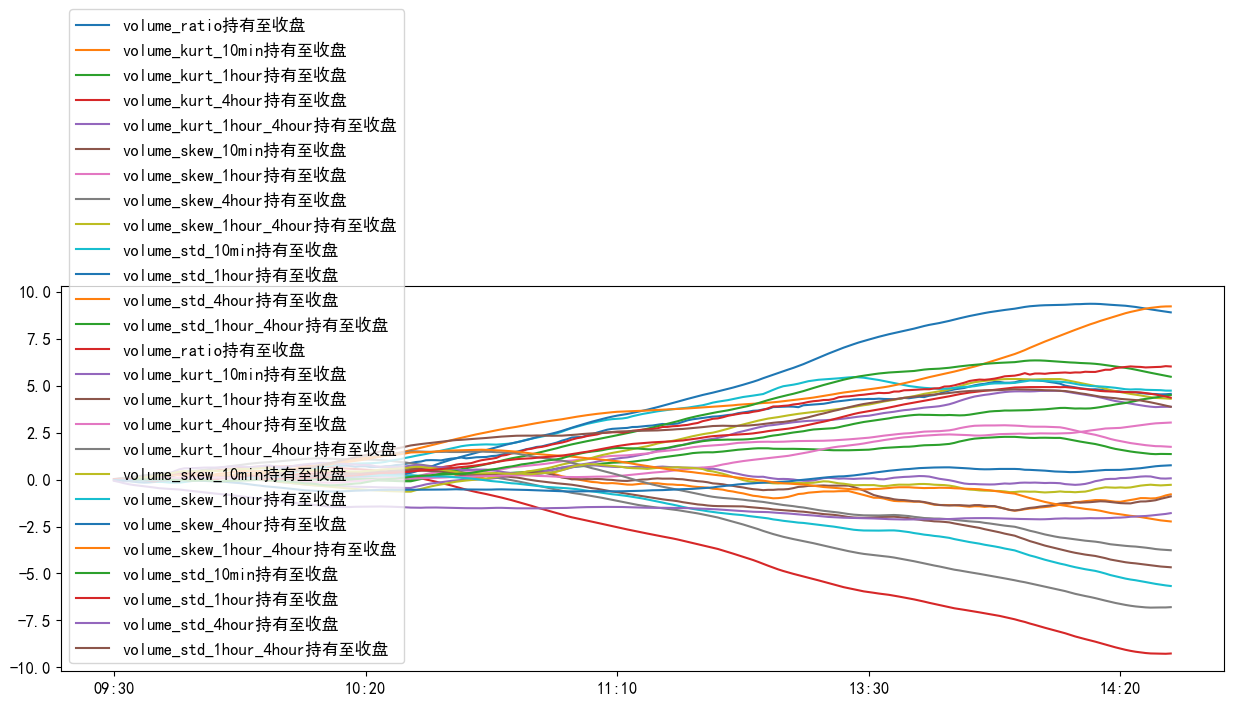

In [ ]:
factor_list = ['volume_ratio',
            'volume_ratio_kurt_10min','volume_ratio_kurt_1hour','volume_ratio_kurt_4hour','volume_ratio_kurt_1hour_4hour',
            'volume_ratio_skew_10min','volume_ratio_skew_1hour','volume_ratio_skew_4hour','volume_ratio_skew_1hour_4hour',
            'volume_ratio_std_10min','volume_ratio_std_1hour','volume_ratio_std_4hour','volume_ratio_std_1hour_4hour']
def volume_ratio_1_factor(minquote):
    minquote.loc[:,'volume_ratio'] = minquote['volume']/minquote['volume'].rolling(480,min_periods=60).mean()
    minquote.loc[:,'volume_ratio_kurt_10min'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).kurt())
    minquote.loc[:,'volume_ratio_kurt_1hour'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).kurt())
    minquote.loc[:,'volume_ratio_kurt_4hour'] = minquote['volume_ratio'].rolling(240,min_periods=120).kurt()
    minquote.loc[:,'volume_ratio_skew_10min'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).skew())
    minquote.loc[:,'volume_ratio_skew_1hour'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).skew())
    minquote.loc[:,'volume_ratio_skew_4hour'] = minquote['volume_ratio'].rolling(240,min_periods=120).skew()
    minquote.loc[:,'volume_ratio_std_10min'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).std())
    minquote.loc[:,'volume_ratio_std_1hour'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).std())
    minquote.loc[:,'volume_ratio_std_4hour'] = minquote['volume_ratio'].rolling(240,min_periods=120).std()
    
    minquote.loc[:,'volume_ratio_kurt_1hour_4hour'] = minquote['volume_kurt_1hour']/minquote['volume_kurt_4hour']
    minquote.loc[:,'volume_ratio_skew_1hour_4hour'] = minquote['volume_skew_1hour']/minquote['volume_skew_4hour']
    minquote.loc[:,'volume_ratio_std_1hour_4hour'] = minquote['volume_std_1hour']/minquote['volume_std_4hour']
    return minquote

FactorIC_ = FactorIC()
FactorIC_.CalcFactors(volume_ratio_1_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

d:\PythonProject1\.conda\Lib\site-packages\pandas\core\window\rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
d:\PythonProject1\.conda\Lib\site-packages\pandas\core\window\rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
d:\PythonProject1\.conda\Lib\site-packages\pandas\core\window\rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
d:\PythonProject1\.conda\Lib\site-packages\pandas\core\window\rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)


F159915: volume_alpha_ratio: 持有至收盘 IC: 0.014, IR: 0.428
F159915: volume_alpha_kurt_10min: 持有至收盘 IC: 0.002, IR: 0.042
F159915: volume_alpha_kurt_1hour: 持有至收盘 IC: 0.012, IR: 0.383
F159915: volume_alpha_kurt_4hour: 持有至收盘 IC: -0.003, IR: -0.114
F159915: volume_alpha_kurt_1hour_4hour: 持有至收盘 IC: 0.006, IR: 0.281
F159915: volume_alpha_skew_10min: 持有至收盘 IC: -0.001, IR: -0.014
F159915: volume_alpha_skew_1hour: 持有至收盘 IC: 0.009, IR: 0.229
F159915: volume_alpha_skew_4hour: 持有至收盘 IC: 0.003, IR: 0.109
F159915: volume_alpha_skew_1hour_4hour: 持有至收盘 IC: -0.005, IR: -0.205
F159915: volume_alpha_std_10min: 持有至收盘 IC: 0.016, IR: 0.601
F159915: volume_alpha_std_1hour: 持有至收盘 IC: 0.025, IR: 0.812
F159915: volume_alpha_std_4hour: 持有至收盘 IC: 0.011, IR: 1.171
F159915: volume_alpha_std_1hour_4hour: 持有至收盘 IC: -0.000, IR: -0.003
F588080: volume_alpha_ratio: 持有至收盘 IC: 0.024, IR: 0.749
F588080: volume_alpha_kurt_10min: 持有至收盘 IC: -0.004, IR: -0.114
F588080: volume_alpha_kurt_1hour: 持有至收盘 IC: -0.033, IR: -0.834
F588080:

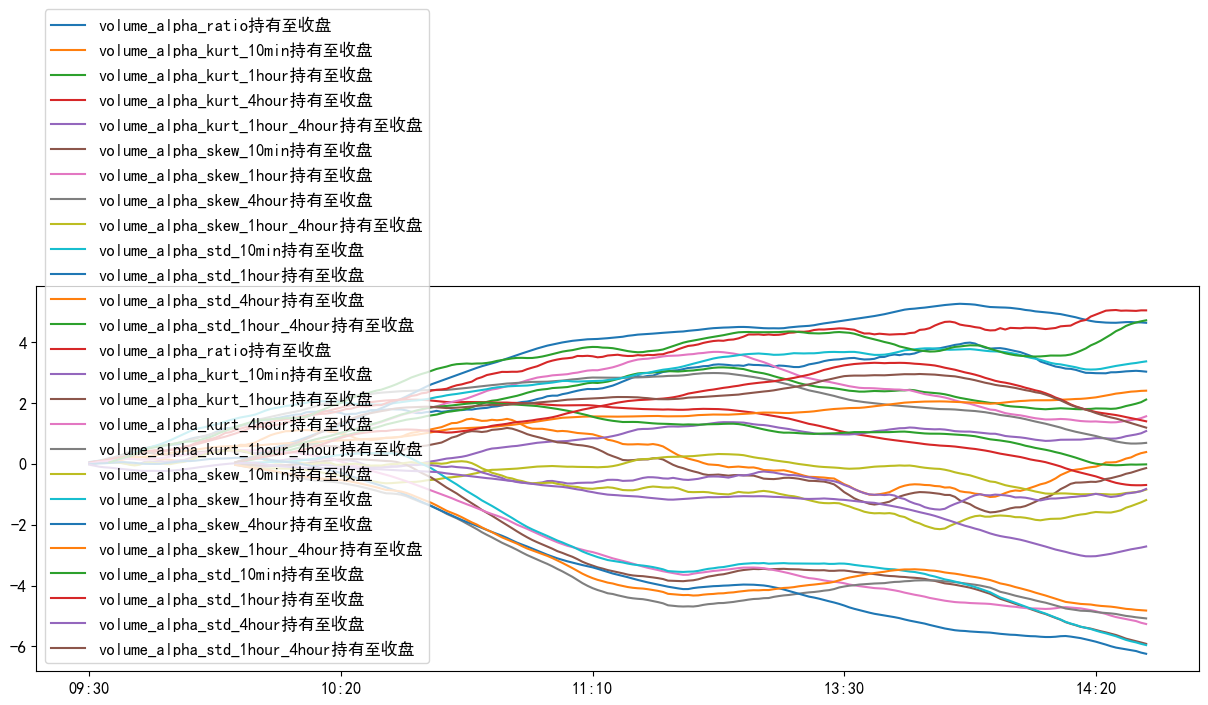

In [3]:
factor_list = ['volume_alpha_ratio',
            'volume_alpha_kurt_10min','volume_alpha_kurt_1hour','volume_alpha_kurt_4hour','volume_alpha_kurt_1hour_4hour',
            'volume_alpha_skew_10min','volume_alpha_skew_1hour','volume_alpha_skew_4hour','volume_alpha_skew_1hour_4hour',
            'volume_alpha_std_10min','volume_alpha_std_1hour','volume_alpha_std_4hour','volume_alpha_std_1hour_4hour']
def volume_ratio_2_factor(minquote):
    minquote.loc[:,'volume_min_mean'] = minquote['volume'].groupby(minquote.index.strftime('%H:%M')).apply(lambda x: x.rolling(5,min_periods=1).mean()).values
    minquote.loc[:,'volume_alpha_ratio'] = minquote['volume']/minquote['volume_min_mean']
    minquote.loc[:,'volume_alpha_kurt_10min'] = minquote['volume_alpha_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).kurt())
    minquote.loc[:,'volume_alpha_kurt_1hour'] = minquote['volume_alpha_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).kurt())
    minquote.loc[:,'volume_alpha_kurt_4hour'] = minquote['volume_alpha_ratio'].rolling(240,min_periods=120).kurt()
    minquote.loc[:,'volume_alpha_skew_10min'] = minquote['volume_alpha_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).skew())
    minquote.loc[:,'volume_alpha_skew_1hour'] = minquote['volume_alpha_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).skew())
    minquote.loc[:,'volume_alpha_skew_4hour'] = minquote['volume_alpha_ratio'].rolling(240,min_periods=120).skew()
    minquote.loc[:,'volume_alpha_std_10min'] = minquote['volume_alpha_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).std())
    minquote.loc[:,'volume_alpha_std_1hour'] = minquote['volume_alpha_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).std())
    minquote.loc[:,'volume_alpha_std_4hour'] = minquote['volume_alpha_ratio'].rolling(240,min_periods=120).std()
    
    minquote.loc[:,'volume_alpha_kurt_1hour_4hour'] = minquote['volume_alpha_kurt_1hour']/minquote['volume_alpha_kurt_4hour']
    minquote.loc[:,'volume_alpha_skew_1hour_4hour'] = minquote['volume_alpha_skew_1hour']/minquote['volume_alpha_skew_4hour']
    minquote.loc[:,'volume_alpha_std_1hour_4hour'] = minquote['volume_alpha_std_1hour']/minquote['volume_alpha_std_4hour']
    return minquote

FactorIC_ = FactorIC()
FactorIC_.CalcFactors(volume_ratio_2_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

F159915: volume: 持有至收盘 IC: 0.032, IR: 0.821
F159915: volume_kurt_10min: 持有至收盘 IC: -0.004, IR: -0.092
F159915: volume_kurt_1hour: 持有至收盘 IC: 0.007, IR: 0.278
F159915: volume_kurt_4hour: 持有至收盘 IC: -0.044, IR: -1.228
F159915: volume_kurt_1hour_4hour: 持有至收盘 IC: 0.021, IR: 0.593
F159915: volume_skew_10min: 持有至收盘 IC: -0.004, IR: -0.111
F159915: volume_skew_1hour: 持有至收盘 IC: 0.010, IR: 0.337
F159915: volume_skew_4hour: 持有至收盘 IC: -0.032, IR: -0.936
F159915: volume_skew_1hour_4hour: 持有至收盘 IC: 0.024, IR: 0.580
F159915: volume_std_10min: 持有至收盘 IC: 0.023, IR: 0.629
F159915: volume_std_1hour: 持有至收盘 IC: 0.049, IR: 1.273
F159915: volume_std_4hour: 持有至收盘 IC: 0.044, IR: 1.561
F159915: volume_std_1hour_4hour: 持有至收盘 IC: 0.030, IR: 0.800
F588080: volume: 持有至收盘 IC: 0.032, IR: 0.946
F588080: volume_kurt_10min: 持有至收盘 IC: 0.000, IR: 0.009
F588080: volume_kurt_1hour: 持有至收盘 IC: -0.026, IR: -0.941
F588080: volume_kurt_4hour: 持有至收盘 IC: 0.014, IR: 0.749
F588080: volume_kurt_1hour_4hour: 持有至收盘 IC: -0.021, IR: -0.545


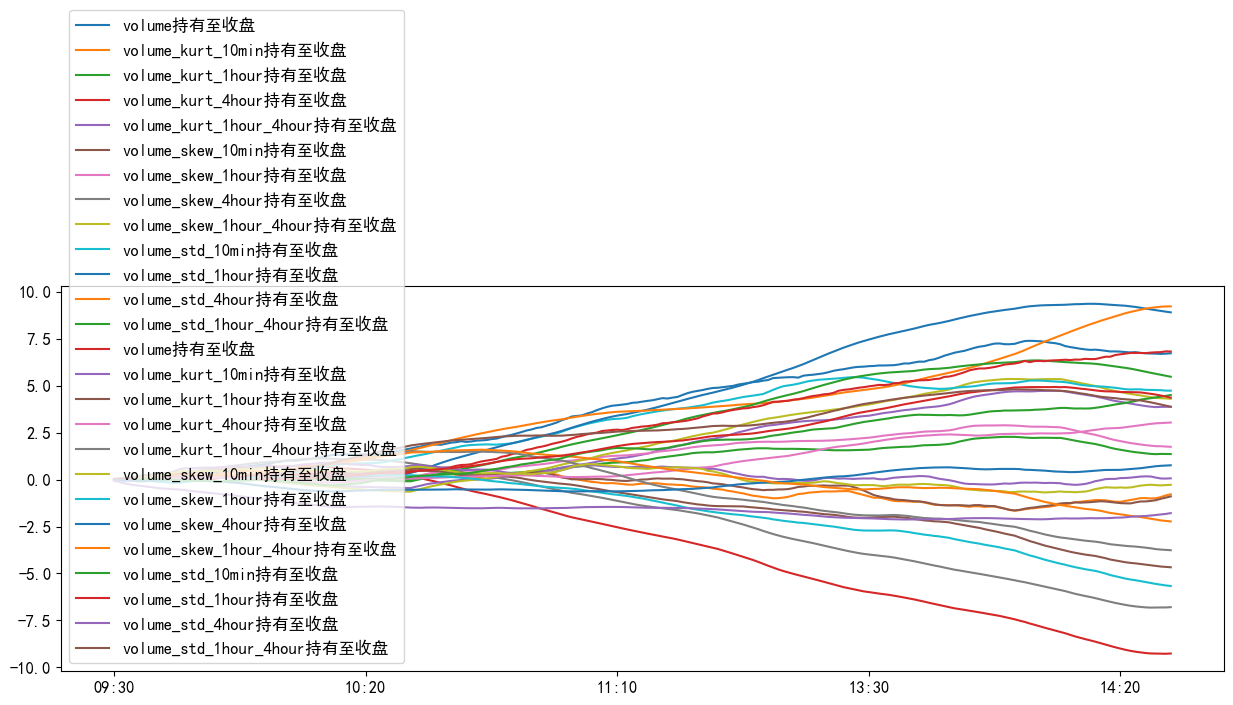

In [ ]:
factor_list = ['volume',
            'volume_kurt_10min','volume_kurt_1hour','volume_kurt_4hour','volume_kurt_1hour_4hour',
            'volume_skew_10min','volume_skew_1hour','volume_skew_4hour','volume_skew_1hour_4hour',
            'volume_std_10min','volume_std_1hour','volume_std_4hour','volume_std_1hour_4hour']
def volume_ratio_3_factor(minquote):
    minquote.loc[:,'volume_kurt_10min'] = minquote['volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).kurt())
    minquote.loc[:,'volume_kurt_1hour'] = minquote['volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).kurt())
    minquote.loc[:,'volume_kurt_4hour'] = minquote['volume'].rolling(240,min_periods=120).kurt()
    minquote.loc[:,'volume_skew_10min'] = minquote['volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).skew())
    minquote.loc[:,'volume_skew_1hour'] = minquote['volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).skew())
    minquote.loc[:,'volume_skew_4hour'] = minquote['volume'].rolling(240,min_periods=120).skew()
    minquote.loc[:,'volume_std_10min'] = minquote['volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).std())
    minquote.loc[:,'volume_std_1hour'] = minquote['volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).std())
    minquote.loc[:,'volume_std_4hour'] = minquote['volume'].rolling(240,min_periods=120).std()
    
    minquote.loc[:,'volume_kurt_1hour_4hour'] = minquote['volume_kurt_1hour']/minquote['volume_kurt_4hour']
    minquote.loc[:,'volume_skew_1hour_4hour'] = minquote['volume_skew_1hour']/minquote['volume_skew_4hour']
    minquote.loc[:,'volume_std_1hour_4hour'] = minquote['volume_std_1hour']/minquote['volume_std_4hour']
    return minquote

FactorIC_ = FactorIC()
FactorIC_.CalcFactors(volume_ratio_1_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

F159915: volume_up_10min: 持有至收盘 IC: 0.043, IR: 1.075
F159915: volume_down_10min: 持有至收盘 IC: 0.007, IR: 0.165
F159915: volume_up_1hour: 持有至收盘 IC: 0.049, IR: 2.026
F159915: volume_down_1hour: 持有至收盘 IC: 0.018, IR: 0.603
F159915: volume_up_4hour: 持有至收盘 IC: 0.018, IR: 0.428
F159915: volume_down_4hour: 持有至收盘 IC: 0.011, IR: 0.375
F159915: volume_up_down_ratio_10min: 持有至收盘 IC: 0.028, IR: 0.646
F159915: volume_up_down_ratio_1hour: 持有至收盘 IC: 0.042, IR: 1.046
F159915: volume_up_down_ratio_4hour: 持有至收盘 IC: 0.033, IR: 0.914
F588080: volume_up_10min: 持有至收盘 IC: 0.042, IR: 1.303
F588080: volume_down_10min: 持有至收盘 IC: 0.005, IR: 0.130
F588080: volume_up_1hour: 持有至收盘 IC: 0.065, IR: 3.143
F588080: volume_down_1hour: 持有至收盘 IC: 0.001, IR: 0.064
F588080: volume_up_4hour: 持有至收盘 IC: 0.036, IR: 0.693
F588080: volume_down_4hour: 持有至收盘 IC: -0.025, IR: -1.068
F588080: volume_up_down_ratio_10min: 持有至收盘 IC: 0.029, IR: 0.822
F588080: volume_up_down_ratio_1hour: 持有至收盘 IC: 0.062, IR: 3.614
F588080: volume_up_down_ratio_

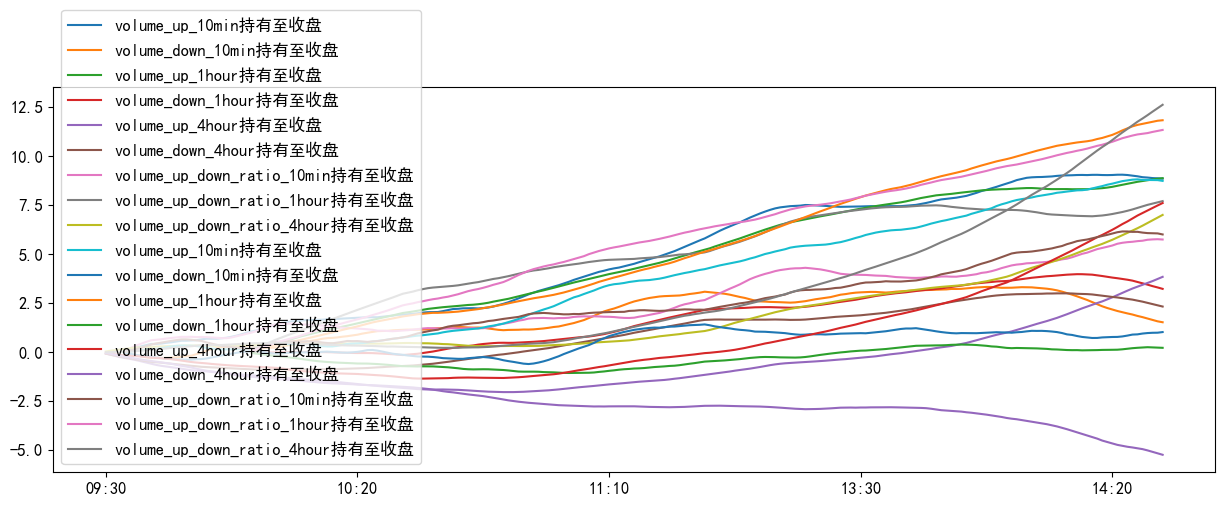

In [21]:
factor_list = ['volume_up_10min','volume_down_10min',
               'volume_up_1hour','volume_down_1hour',
               'volume_up_4hour','volume_down_4hour',
               'volume_up_down_ratio_10min','volume_up_down_ratio_1hour',
               'volume_up_down_ratio_4hour']

def volume_up_down_ratio(minquote):
    minquote.loc[:,'ret_min'] = minquote['close']/minquote['open']-1
    minquote.loc[:,'up_volume'] = minquote['volume']*(minquote['ret_min']>0)
    minquote.loc[:,'down_volume'] = minquote['volume']*(minquote['ret_min']<0)
    minquote.loc[:,'volume_up_10min'] = minquote['up_volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).sum())
    minquote.loc[:,'volume_down_10min'] = minquote['down_volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).sum())
    minquote.loc[:,'volume_up_1hour'] = minquote['up_volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).sum())
    minquote.loc[:,'volume_down_1hour'] = minquote['down_volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).sum())
    minquote.loc[:,'volume_up_4hour'] = minquote['up_volume'].rolling(240,min_periods=120).sum()
    minquote.loc[:,'volume_down_4hour'] = minquote['down_volume'].rolling(240,min_periods=120).sum()
    minquote.loc[:,'volume_up_down_ratio_10min'] = minquote['volume_up_10min']/minquote['volume_down_10min']
    minquote.loc[:,'volume_up_down_ratio_1hour'] = minquote['volume_up_1hour']/minquote['volume_down_1hour']
    minquote.loc[:,'volume_up_down_ratio_4hour'] = minquote['volume_up_4hour']/minquote['volume_down_4hour']
    return minquote

FactorIC_ = FactorIC()
FactorIC_.CalcFactors(volume_up_down_ratio)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

<Axes: >

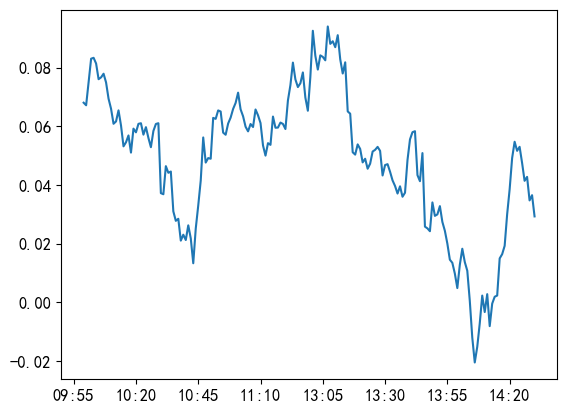

In [14]:
FactorIC_.ICresult['F159915']['volume_up_1hour'].plot()

平均持仓时间: 79.143448 分钟
胜率：0.506250
年化收益率：0.374906
年化夏普比率：2.712020


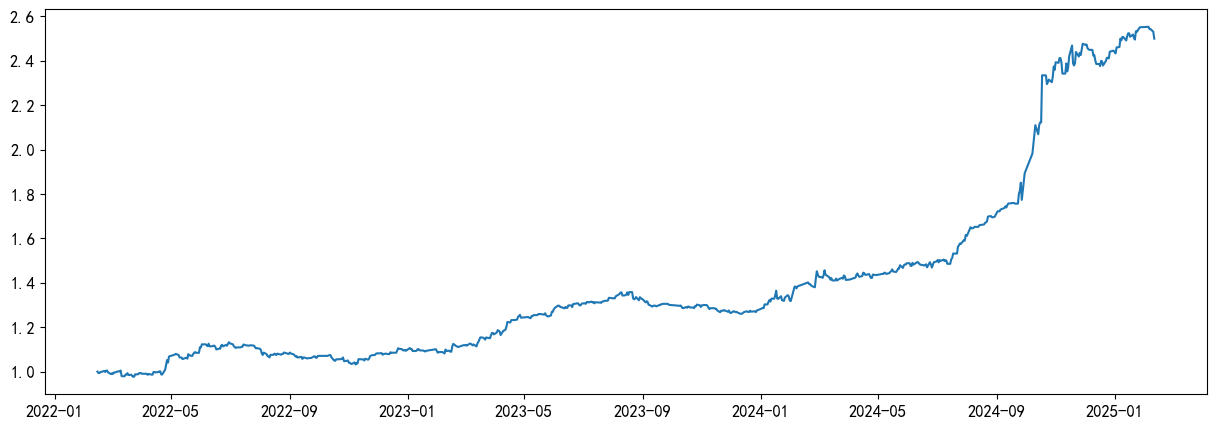

In [22]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'volume_up_1hour',
    direction = 1,
    periods = [('10:59','13:59')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.5,
    lower_stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.2 上下行波动占比

In [16]:
factor_list = ['downstd_ratio_10min','downstd_ratio_1hour','downstd_ratio_4hour']
def downstd_ratio_factor(minquote):
    minquote.loc[:,'ret_min'] = minquote['close']/minquote['open']-1
    minquote.loc[:,'downstd_ratio_10min'] = (minquote['ret_min']<0) *(minquote['ret_min']**2).rolling(10,min_periods=5).sum()/(minquote['ret_min']**2).rolling(10,min_periods=5).sum()
    minquote.loc[:,'downstd_ratio_1hour'] = (minquote['ret_min']<0) *(minquote['ret_min']**2).rolling(60,min_periods=30).sum()/(minquote['ret_min']**2).rolling(60,min_periods=30).sum()
    minquote.loc[:,'downstd_ratio_4hour'] = (minquote['ret_min']<0) *(minquote['ret_min']**2).rolling(240,min_periods=120).sum()/(minquote['ret_min']**2).rolling(240,min_periods=120).sum()
    return minquote

downstd_ratio_10min: 持有至收盘 IC: -0.007, IR: -0.192
downstd_ratio_1hour: 持有至收盘 IC: -0.007, IR: -0.191
downstd_ratio_4hour: 持有至收盘 IC: -0.007, IR: -0.191
downstd_ratio_10min: 持有至收盘 IC: -0.007, IR: -0.162
downstd_ratio_1hour: 持有至收盘 IC: -0.007, IR: -0.154
downstd_ratio_4hour: 持有至收盘 IC: -0.006, IR: -0.151


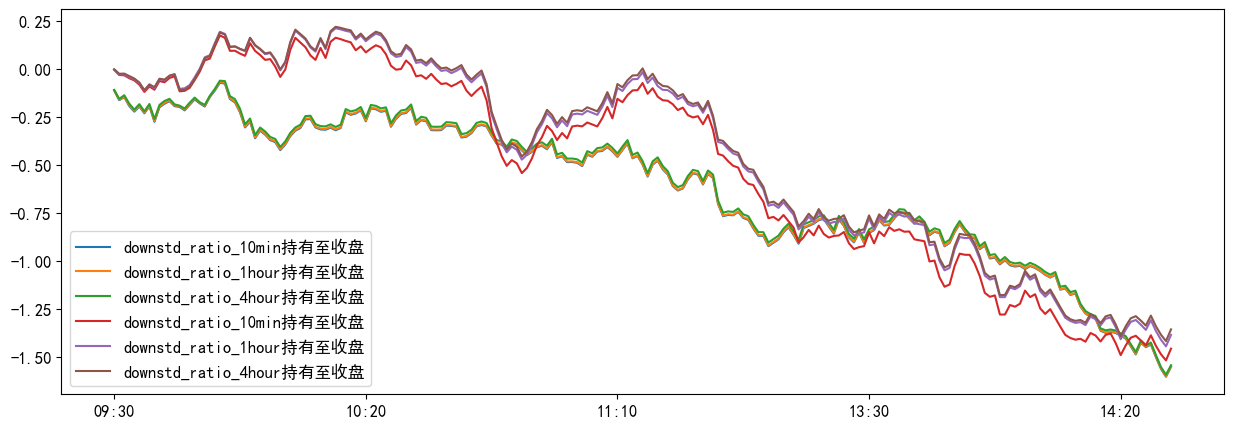

In [17]:
FactorIC_ = FactorIC()
FactorIC_.CalcFactors(downstd_ratio_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 207.314483 分钟
胜率：0.468966
年化收益率：0.043603
年化夏普比率：0.195140


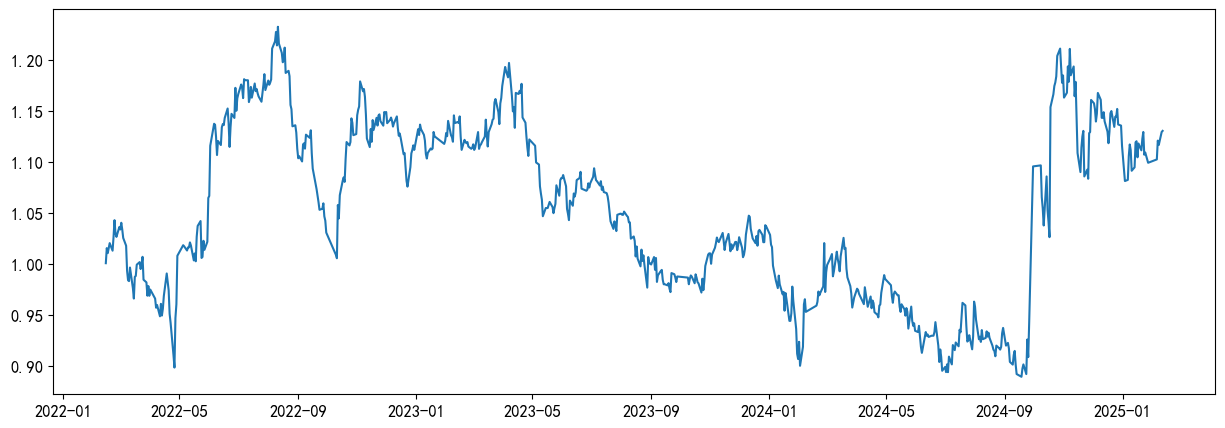

In [ ]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'downstd_ratio_10min',
    direction = 1,
    periods = [('09:59','10:59'),('13:29','14:29')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.5,
    lower_stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.3 amihud 非流动性 **

F159915: amihud_mean_1hour: 持有至收盘 IC: -0.027, IR: -1.281
F159915: amihud_vwap_corr_1hour: 持有至收盘 IC: -0.042, IR: -0.835
F588080: amihud_mean_4hour: 持有至收盘 IC: 0.024, IR: 0.622
F588080: amihud_vwap_corr_10min: 持有至收盘 IC: -0.025, IR: -0.602
F588080: amihud_vwap_corr_1hour: 持有至收盘 IC: -0.044, IR: -1.101
F588080: amihud_vwap_corr_4hour: 持有至收盘 IC: 0.032, IR: 1.991


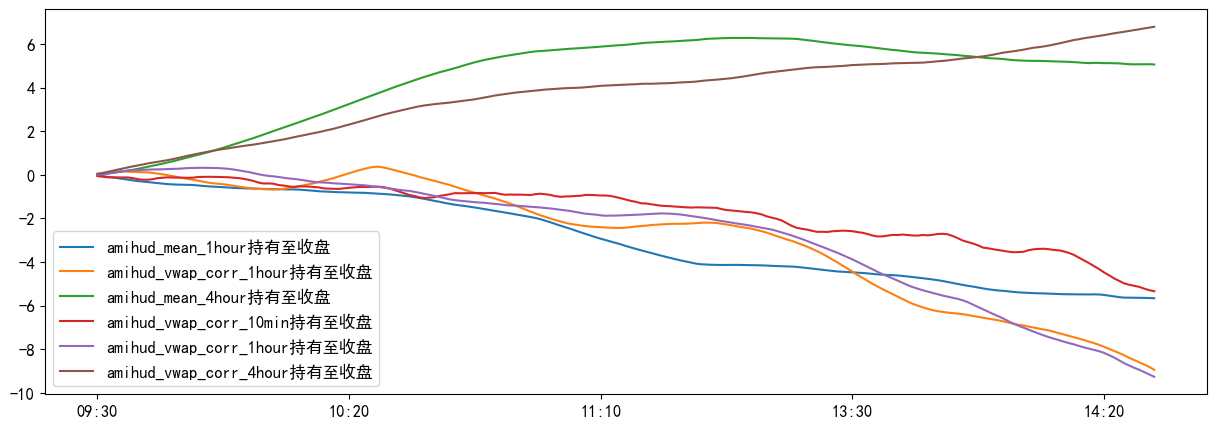

In [45]:
factor_list = ['amihud']
def amihud_factor(minquote):
    minquote.loc[:,'ret_min_abs'] = (minquote['close']/minquote['open']-1).abs()
    minquote.loc[:,'amihud'] = minquote['ret_min_abs']/minquote['amount']
    return minquote

FactorIC_ = FactorIC(factor_is_min=True,rolling_window=1200)
FactorIC_.CalcFactors(amihud_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

In [48]:
result2

持有至收盘IC   持有至收盘IR
amihud                       -0.007367 -0.225306
amihud_mean_10min            -0.019118 -0.615935
amihud_mean_1hour            -0.005606 -0.203446
amihud_mean_4hour             0.024003  0.621600
amihud_mean_10min_1hour      -0.012861 -0.393379
amihud_vwap_corr_10min       -0.025317 -0.602417
amihud_vwap_corr_1hour       -0.043925 -1.100998
amihud_vwap_corr_4hour        0.032203  1.990663
amihud_vwap_corr_10min_1hour -0.000411 -0.011249

In [47]:
result1

持有至收盘IC   持有至收盘IR
amihud                       -0.007552 -0.208919
amihud_mean_10min            -0.017178 -0.424063
amihud_mean_1hour            -0.026843 -1.280816
amihud_mean_4hour             0.001035  0.045937
amihud_mean_10min_1hour      -0.000618 -0.015213
amihud_vwap_corr_10min       -0.020232 -0.498246
amihud_vwap_corr_1hour       -0.042405 -0.835221
amihud_vwap_corr_4hour        0.017089  1.342066
amihud_vwap_corr_10min_1hour -0.011956 -0.346730

<Axes: >

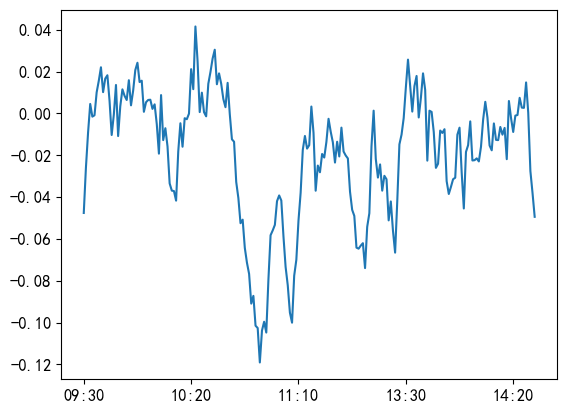

In [50]:
FactorIC_.ICresult['F588080']['amihud_mean_10min'].plot()

<Axes: >

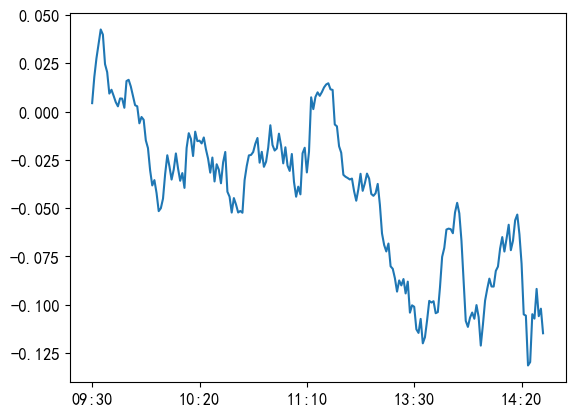

In [54]:
FactorIC_.ICresult['F588080']['amihud_vwap_corr_1hour'].plot()

平均持仓时间: 30.33 分钟
平均每日交易次数: 1.00
胜率：0.50
平均单次盈利: 0.004
平均单次亏损: -0.004
平均单次盈利/亏损: 1.154
年化收益率：0.072
年化波动率：0.103
年化夏普比率：0.705
最大回撤: 0.111
Calmar比率: 0.650


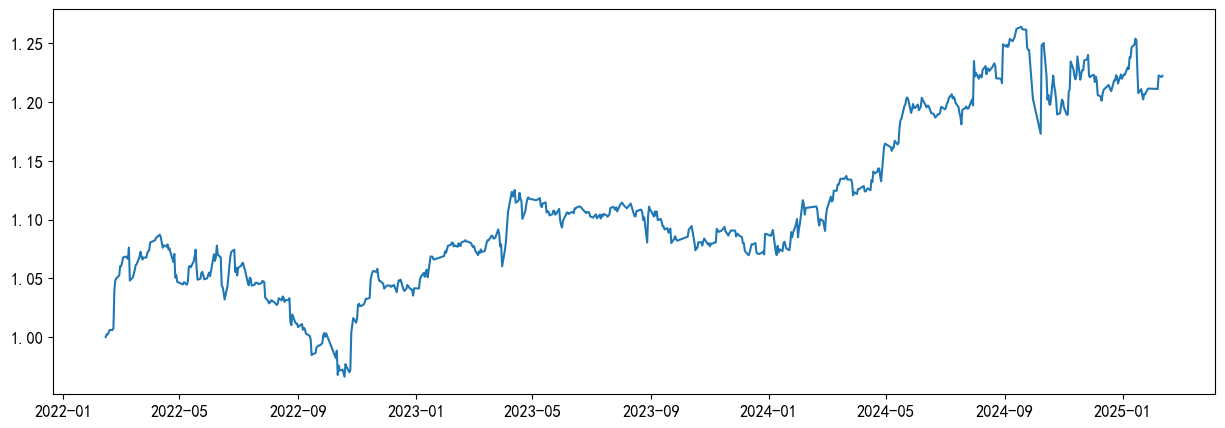

In [53]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'amihud_mean_10min',
    direction = -1,
    periods = [('09:30','13:30')],
    rolling_is_rank = True,
    rolling_window = 1200,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.5,
    lower_stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

平均持仓时间: 36.20 分钟
平均每日交易次数: 0.94
胜率：0.48
平均单次盈利: 0.004
平均单次亏损: -0.003
平均单次盈利/亏损: 1.413
年化收益率：0.110
年化波动率：0.094
年化夏普比率：1.161
最大回撤: 0.082
Calmar比率: 1.330


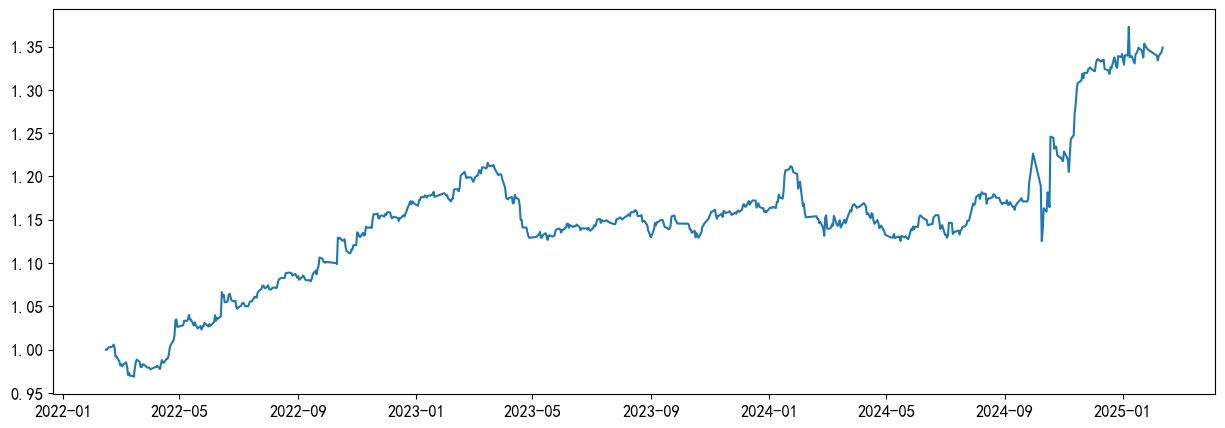

In [ ]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'amihud_vwap_corr_1hour',
    direction = -1,
    periods = [('12:59','14:50')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.5,
    lower_stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.4 成交量自相关系数

In [20]:
factor_list = ['amihud_10min','amihud_1hour','amihud_4hour']
def volume_autocorr_factor(minquote):
    minquote.loc[:,'ret_min_abs'] = minquote.groupby(minquote.index.date).apply(lambda x:(x['close']/x['open']-1)).abs().values
    minquote.loc[:,'amihud_10min'] = (minquote.loc[:,'ret_min_abs']/minquote.loc[:,'amount']).rolling(10,min_periods=5).sum()
    minquote.loc[:,'amihud_1hour'] = (minquote.loc[:,'ret_min_abs']/minquote.loc[:,'amount']).rolling(60,min_periods=30).sum()
    minquote.loc[:,'amihud_4hour'] = (minquote.loc[:,'ret_min_abs']/minquote.loc[:,'amount']).rolling(240,min_periods=120).sum()
    return minquote

#### 3.1.5 振幅因子 *

F159915: HML_mean_10min: 持有至收盘 IC: 0.037, IR: 1.104
F159915: HML_mean_1hour: 持有至收盘 IC: 0.046, IR: 1.687
F159915: HML_mean_4hour: 持有至收盘 IC: 0.028, IR: 1.914
F159915: HML_vwap_corr_4hour: 持有至收盘 IC: -0.029, IR: -0.552
F159915: HML_C_mean_10min: 持有至收盘 IC: 0.037, IR: 1.101
F159915: HML_C_mean_1hour: 持有至收盘 IC: 0.046, IR: 1.682
F159915: HML_C_mean_4hour: 持有至收盘 IC: 0.028, IR: 1.913
F159915: HML_C_vwap_corr_4hour: 持有至收盘 IC: -0.028, IR: -0.549
F588080: HML_vwap_corr_4hour: 持有至收盘 IC: -0.025, IR: -0.600
F588080: HML_C_vwap_corr_4hour: 持有至收盘 IC: -0.025, IR: -0.599


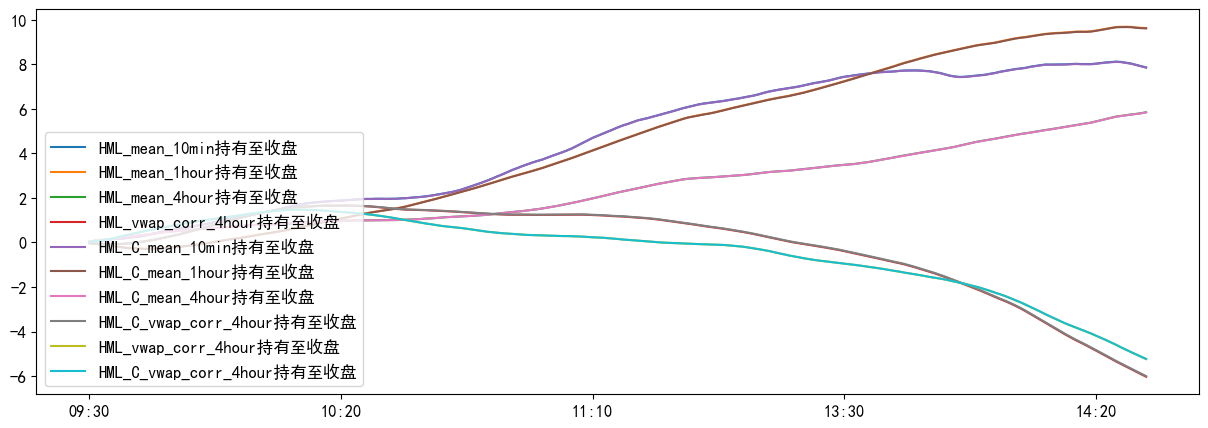

In [67]:
factor_list = ['HML','HML_C']
def HML_factor(minquote):
    minquote.loc[:,'HML'] = minquote['high']/minquote['low']-1
    minquote.loc[:,'HML_C'] = (minquote['high']-minquote['low'])/minquote['close']
    return minquote

FactorIC_ = FactorIC(factor_is_min = True, rolling_window = 1200)
FactorIC_.CalcFactors(HML_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

<Axes: >

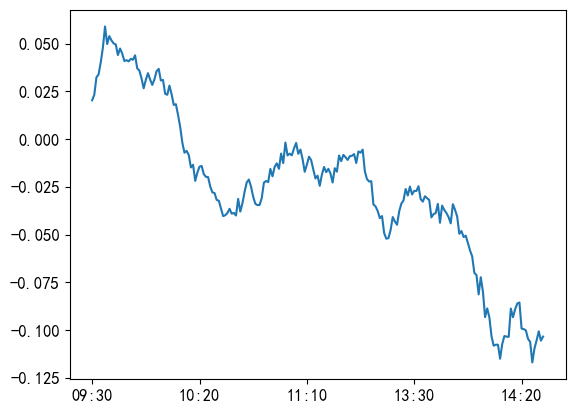

In [68]:
FactorIC_.ICresult['F588080']['HML_vwap_corr_4hour'].plot()

平均持仓时间: 27.63 分钟
平均每日交易次数: 0.63
胜率：0.53
平均单次盈利: 0.004
平均单次亏损: -0.003
平均单次盈利/亏损: 1.166
年化收益率：0.080
年化波动率：0.068
年化夏普比率：1.185
最大回撤: 0.058
Calmar比率: 1.377


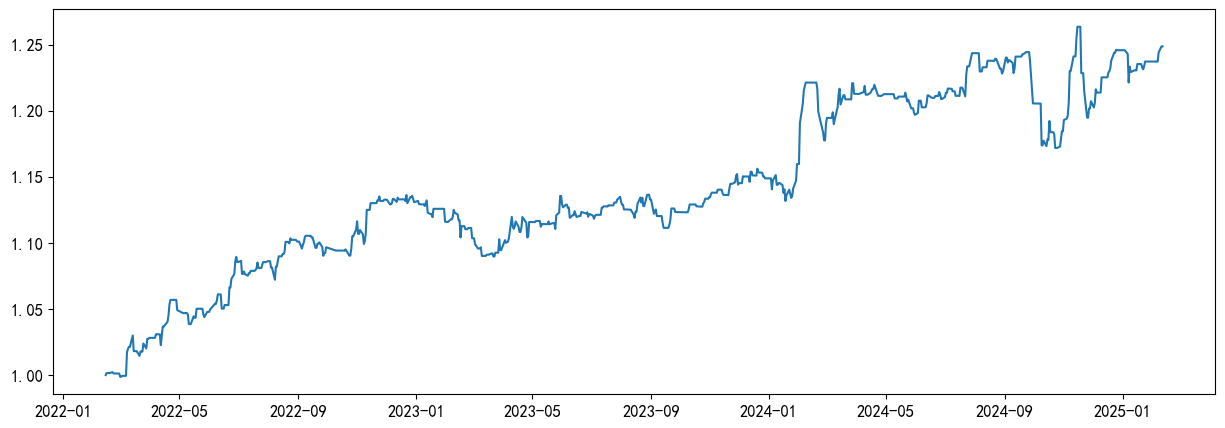

In [69]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'HML_vwap_corr_4hour',
    direction = -1,
    periods = [('13:59','14:50')],
    rolling_is_rank = True,
    rolling_window = 1200,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.6,
    lower_stop_bound = 0.4,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.6 上下影线占比 *

F159915: HMC_CML_mean_10min: 持有至收盘 IC: -0.032, IR: -0.723
F159915: HMC_CML_mean_1hour: 持有至收盘 IC: -0.052, IR: -1.258
F159915: HMC_CML_mean_4hour: 持有至收盘 IC: -0.026, IR: -0.710
F588080: HMC_CML_mean_10min: 持有至收盘 IC: -0.027, IR: -0.698
F588080: HMC_CML_mean_1hour: 持有至收盘 IC: -0.065, IR: -3.571
F588080: HMC_CML_mean_4hour: 持有至收盘 IC: -0.059, IR: -1.430
F588080: HMC_OML_vwap_corr_4hour: 持有至收盘 IC: 0.051, IR: 1.879
F588080: H_OC_L_vwap_corr_4hour: 持有至收盘 IC: 0.051, IR: 1.879


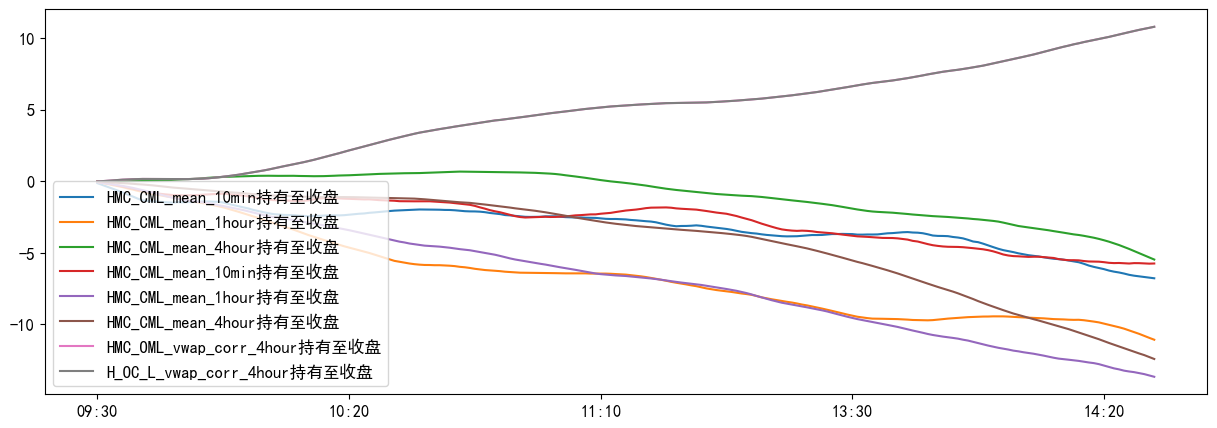

In [70]:
# 上下影线太多为0，所以不能求比值，求差
factor_list = ['HMC_CML','HMC_OML','H_OC_L']
def shadow_factor(minquote):
    minquote.loc[:,'HMC_CML'] = (minquote['high']-minquote['close'])-(minquote['close']-minquote['low'])
    minquote.loc[:,'HMC_OML'] = (minquote['high']-minquote['close'])-(minquote['open']-minquote['low'])
    minquote.loc[:,'H_OC_L'] = (minquote['high']-minquote[['open','close']].max(axis=1))-(minquote[['open','close']].min(axis=1)-minquote['low'])
    return minquote

FactorIC_ = FactorIC(factor_is_min=True,rolling_window=1200)
FactorIC_.CalcFactors(shadow_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

<Axes: >

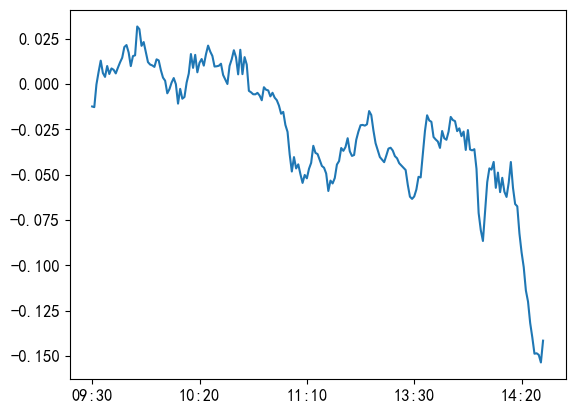

In [71]:
FactorIC_.ICresult['F159915']['HMC_CML_mean_4hour'].plot()

<Axes: >

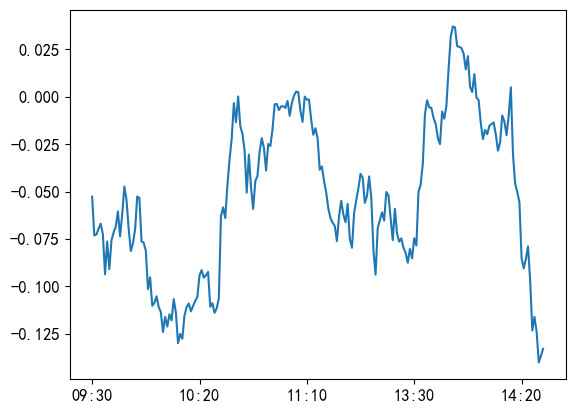

In [72]:
FactorIC_.ICresult['F159915']['HMC_CML_mean_1hour'].plot()

平均持仓时间: 39.94 分钟
平均每日交易次数: 1.00
胜率：0.42
平均单次盈利: 0.004
平均单次亏损: -0.003
平均单次盈利/亏损: 1.420
年化收益率：0.011
年化波动率：0.085
年化夏普比率：0.124
最大回撤: 0.101
Calmar比率: 0.104


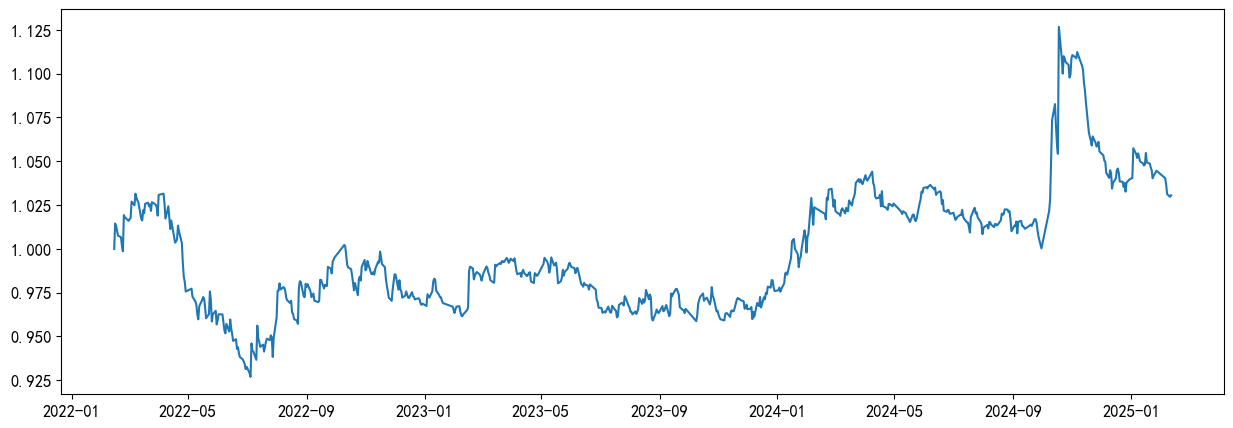

In [ ]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F159915'],
    factor_name = 'HMC_CML_mean_4hour',
    direction = -1,
    periods = [('09:59','14:50')],
    rolling_is_rank = True,
    rolling_window = 1200,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.6,
    lower_stop_bound = 0.4,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.7 量价相关性因子 *

F159915: price_volume_corr_10min: 持有至收盘 IC: 0.032, IR: 0.710
F159915: price_volume_corr_1hour: 持有至收盘 IC: 0.043, IR: 1.035
F159915: price_volume1_corr_10min: 持有至收盘 IC: 0.031, IR: 0.739
F159915: price_volume1_corr_1hour: 持有至收盘 IC: 0.047, IR: 1.103
F159915: ret_volume_corr_1hour: 持有至收盘 IC: 0.052, IR: 0.937
F159915: ret_volume_corr_4hour: 持有至收盘 IC: 0.086, IR: 5.484
F159915: ret_volume1_corr_4hour: 持有至收盘 IC: -0.021, IR: -0.524
F588080: price_volume_corr_10min: 持有至收盘 IC: 0.029, IR: 0.620
F588080: price_volume_corr_1hour: 持有至收盘 IC: 0.031, IR: 0.916
F588080: price_volume_corr_4hour: 持有至收盘 IC: -0.025, IR: -0.659
F588080: price_volume1_corr_10min: 持有至收盘 IC: 0.027, IR: 0.661
F588080: price_volume1_corr_1hour: 持有至收盘 IC: 0.033, IR: 1.019
F588080: price_volume1_corr_4hour: 持有至收盘 IC: -0.024, IR: -0.588
F588080: ret_volume_corr_10min: 持有至收盘 IC: 0.033, IR: 0.924
F588080: ret_volume_corr_1hour: 持有至收盘 IC: 0.071, IR: 3.249
F588080: ret_volume_corr_4hour: 持有至收盘 IC: 0.065, IR: 1.576
F588080: ret_volume1_cor

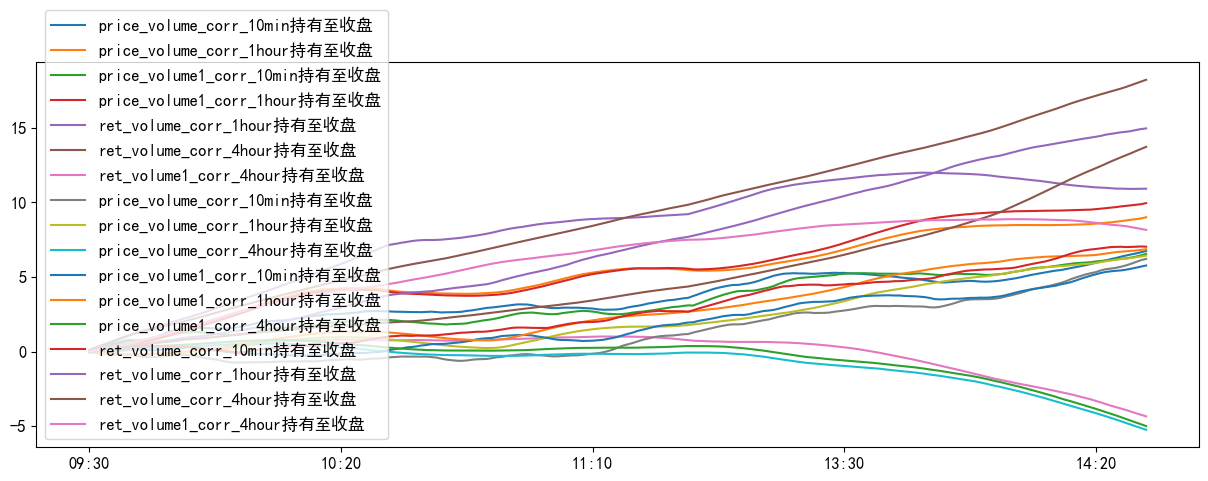

In [77]:
factor_list = ['price_volume_corr_10min','price_volume_corr_1hour','price_volume_corr_4hour',
               'price_volume1_corr_10min','price_volume1_corr_1hour','price_volume1_corr_4hour',
               'ret_volume_corr_10min','ret_volume_corr_1hour','ret_volume_corr_4hour',
               'ret_volume1_corr_10min','ret_volume1_corr_1hour','ret_volume1_corr_4hour',
               'price_volume_corr_10min_1hour','ret_volume_corr_10min_1hour',]
def price_volume_corr_factor(minquote):
    minquote.loc[:,'volume_ratio'] = minquote['volume']/minquote['volume'].rolling(480,min_periods=60).mean()
    minquote.loc[:,'ret_min'] = minquote['close']/minquote['open']-1
    minquote.loc[:,'price_volume_corr_10min'] = minquote['close'].rolling(10,min_periods=5).corr(minquote['volume_ratio'])
    minquote.loc[:,'price_volume_corr_1hour'] = minquote['close'].rolling(60,min_periods=30).corr(minquote['volume_ratio'])
    minquote.loc[:,'price_volume_corr_4hour'] = minquote['close'].rolling(240,min_periods=120).corr(minquote['volume_ratio'])
    minquote.loc[:,'price_volume1_corr_10min'] = minquote['close'].rolling(10,min_periods=5).corr(minquote['volume_ratio'].shift())
    minquote.loc[:,'price_volume1_corr_1hour'] = minquote['close'].rolling(60,min_periods=30).corr(minquote['volume_ratio'].shift())
    minquote.loc[:,'price_volume1_corr_4hour'] = minquote['close'].rolling(240,min_periods=120).corr(minquote['volume_ratio'].shift())
    
    minquote.loc[:,'ret_volume_corr_10min'] = minquote['ret_min'].rolling(10,min_periods=5).corr(minquote['volume_ratio'])
    minquote.loc[:,'ret_volume_corr_1hour'] = minquote['ret_min'].rolling(60,min_periods=30).corr(minquote['volume_ratio'])
    minquote.loc[:,'ret_volume_corr_4hour'] = minquote['ret_min'].rolling(240,min_periods=120).corr(minquote['volume_ratio'])
    minquote.loc[:,'ret_volume1_corr_10min'] = minquote['ret_min'].rolling(10,min_periods=5).corr(minquote['volume_ratio'].shift())
    minquote.loc[:,'ret_volume1_corr_1hour'] = minquote['ret_min'].rolling(60,min_periods=30).corr(minquote['volume_ratio'].shift())
    minquote.loc[:,'ret_volume1_corr_4hour'] = minquote['ret_min'].rolling(240,min_periods=120).corr(minquote['volume_ratio'].shift())

    minquote.loc[:,'price_volume_corr_10min_1hour'] = minquote['price_volume_corr_10min']/minquote['price_volume_corr_1hour']
    minquote.loc[:,'ret_volume_corr_10min_1hour'] = minquote['ret_volume_corr_10min']/minquote['ret_volume_corr_1hour']
    return minquote

FactorIC_ = FactorIC(rolling_window=1200)
FactorIC_.CalcFactors(price_volume_corr_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 112.333793 分钟
胜率：0.519369
年化收益率：0.444527
年化夏普比率：2.859394


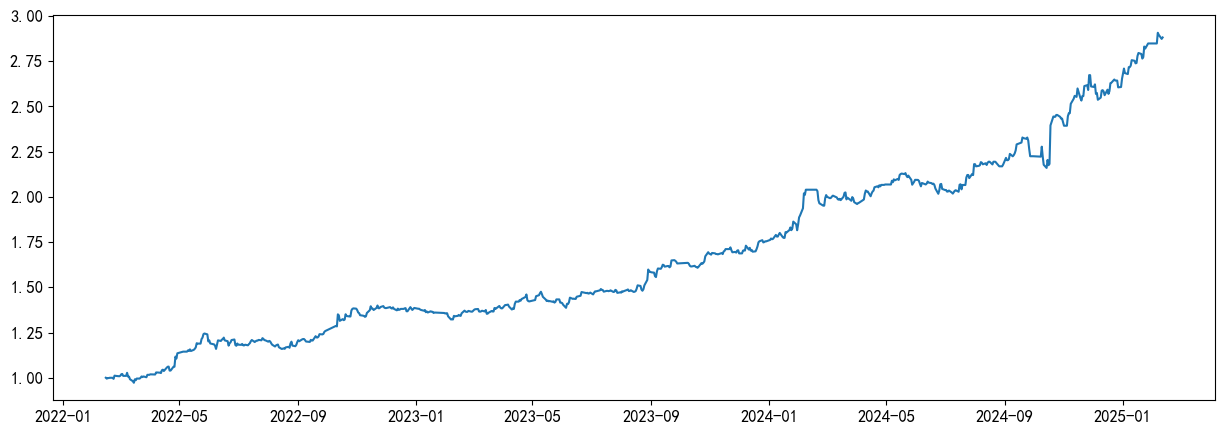

In [ ]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'ret_volume_corr_4hour',
    direction = 1,
    periods = [('09:59','14:50')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.6,
    lower_stop_bound = 0.4,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.8 RSI指标 *

F159915: RSI_10min: 持有至收盘 IC: 0.037, IR: 0.889
F159915: RSI_1hour: 持有至收盘 IC: 0.069, IR: 1.798
F159915: RSI_4hour: 持有至收盘 IC: 0.051, IR: 1.219
F588080: RSI_10min: 持有至收盘 IC: 0.044, IR: 1.075
F588080: RSI_1hour: 持有至收盘 IC: 0.086, IR: 2.130
F588080: RSI_4hour: 持有至收盘 IC: 0.067, IR: 1.103


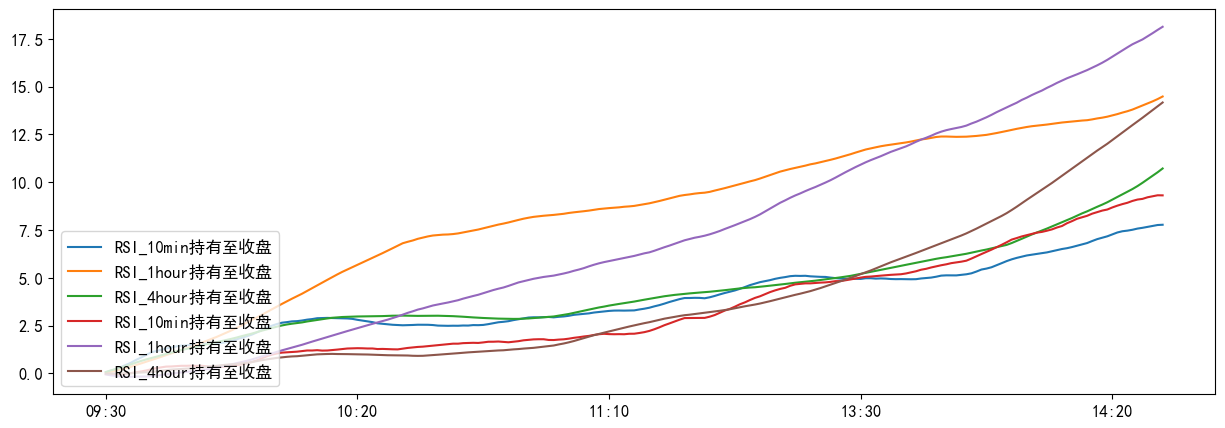

In [78]:
factor_list = ['RSI_10min','RSI_1hour','RSI_4hour']
def RSI_factor(minquote):
    minquote.loc[:,'close_diff'] = minquote['close'] - minquote['close'].shift(1)
    minquote.loc[:,'RSI_10min'] = -(minquote['close_diff']*(minquote['close_diff'] > 0)).rolling(10,min_periods=5).mean() / (minquote['close_diff']*(minquote['close_diff'] < 0)).rolling(10,min_periods=5).mean()
    minquote.loc[:,'RSI_1hour'] = -(minquote['close_diff']*(minquote['close_diff'] > 0)).rolling(60,min_periods=30).mean() / (minquote['close_diff']*(minquote['close_diff'] < 0)).rolling(60,min_periods=30).mean()
    minquote.loc[:,'RSI_4hour'] = -(minquote['close_diff']*(minquote['close_diff'] > 0)).rolling(240,min_periods=120).mean() / (minquote['close_diff']*(minquote['close_diff'] < 0)).rolling(240,min_periods=120).mean()
    return minquote

FactorIC_ = FactorIC(rolling_window=1200)
FactorIC_.CalcFactors(RSI_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 35.95 分钟
平均每日交易次数: 0.8468965517241379
胜率：0.40
年化收益率：0.244
年化波动率：0.104
年化夏普比率：2.351
最大回撤: 0.075
Calmar比率: 3.250


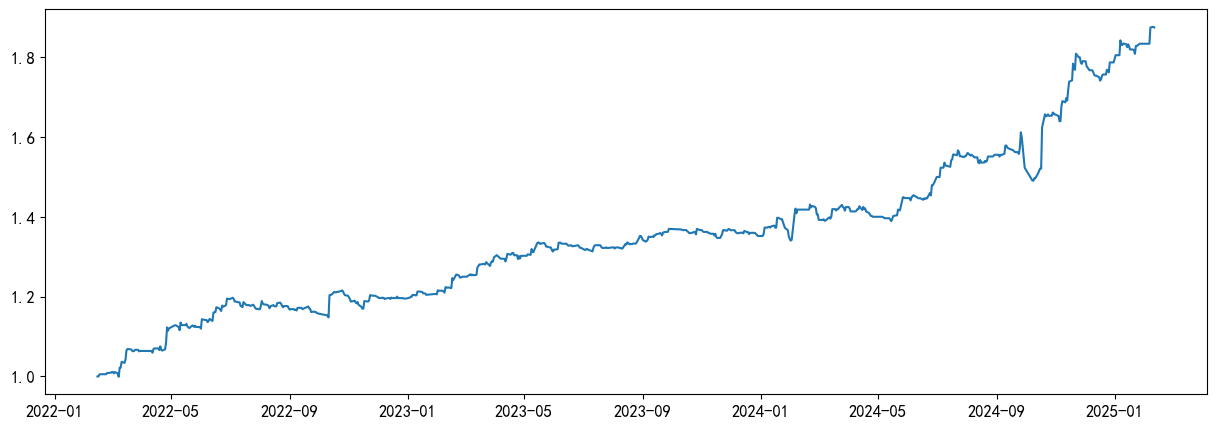

In [4]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'RSI_1hour',
    direction = 1,
    periods = [('12:59','14:30')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.9,
    lower_bound = 0.1,
    upper_stop_bound = 0.6,
    lower_stop_bound = 0.4,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.9 MACD指标 *

F159915: MACD_10min_30min: 持有至收盘 IC: 0.070, IR: 1.460
F159915: MACD_30min_1hour: 持有至收盘 IC: 0.076, IR: 2.036
F159915: MACD_1hour_4hour: 持有至收盘 IC: 0.087, IR: 3.136
F588080: MACD_10min_30min: 持有至收盘 IC: 0.087, IR: 1.914
F588080: MACD_30min_1hour: 持有至收盘 IC: 0.092, IR: 1.913
F588080: MACD_1hour_4hour: 持有至收盘 IC: 0.080, IR: 1.555


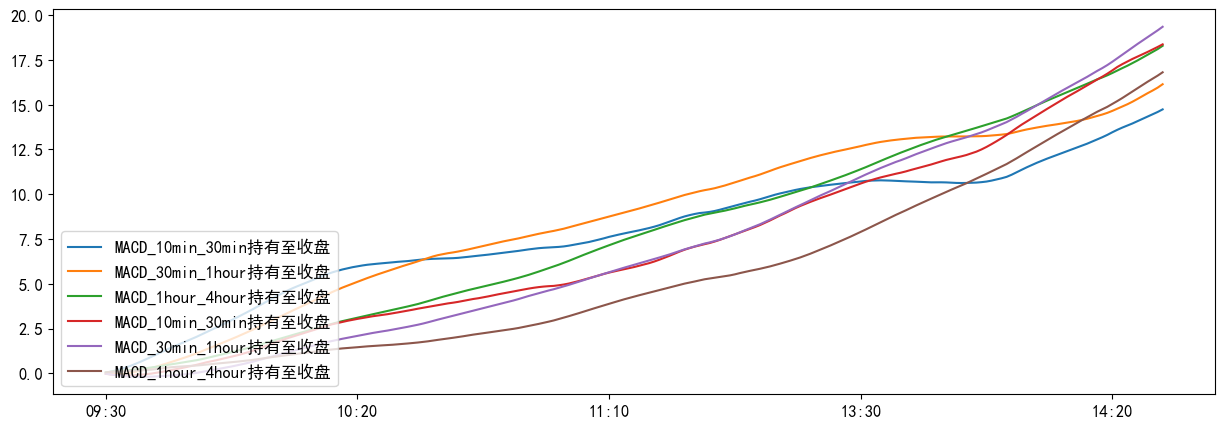

In [81]:
factor_list = ['MACD_10min_30min','MACD_30min_1hour','MACD_1hour_4hour']
def MACD_factor(minquote):
    minquote.loc[:,'EMA_10min'] = minquote['close'].ewm(span=10,min_periods=5).mean()
    minquote.loc[:,'EMA_30min'] = minquote['close'].ewm(span=30,min_periods=15).mean()
    minquote.loc[:,'EMA_1hour'] = minquote['close'].ewm(span=60,min_periods=30).mean()
    minquote.loc[:,'EMA_4hour'] = minquote['close'].ewm(span=240,min_periods=120).mean()

    minquote.loc[:,'MACD_10min_30min'] = minquote['EMA_10min'] - minquote['EMA_30min']
    minquote.loc[:,'MACD_30min_1hour'] = minquote['EMA_30min'] - minquote['EMA_1hour']
    minquote.loc[:,'MACD_1hour_4hour'] = minquote['EMA_1hour'] - minquote['EMA_4hour']
    return minquote

FactorIC_ = FactorIC(rolling_window=1200)
FactorIC_.CalcFactors(MACD_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 113.513103 分钟
胜率：0.494234
年化收益率：0.478690
年化夏普比率：2.858506


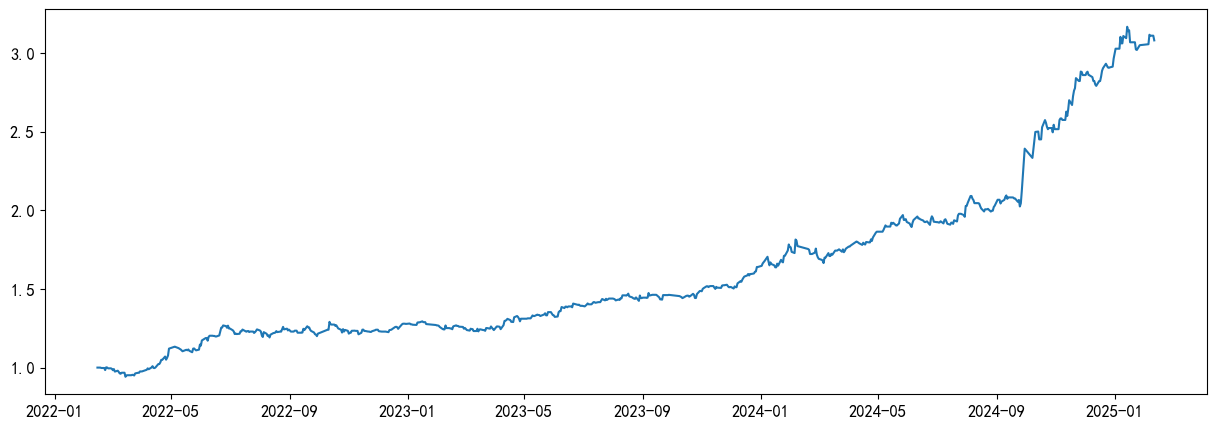

In [ ]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'MACD_1hour_4hour',
    direction = 1,
    periods = [('09:59','10:59'),('13:29','14:29')],
    rolling_is_rank = True,
    rolling_window = 960,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.6,
    lower_stop_bound = 0.4,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.10 boll 指标 *

F159915: BOLLup_10min: 持有至收盘 IC: 0.064, IR: 2.049
F159915: BOLLup_30min: 持有至收盘 IC: 0.059, IR: 1.677
F159915: BOLLup_1hour: 持有至收盘 IC: 0.053, IR: 1.443
F159915: BOLLup_4hour: 持有至收盘 IC: 0.040, IR: 1.840
F159915: close_BOLLup_30min: 持有至收盘 IC: 0.027, IR: 0.624
F159915: close_BOLLup_1hour: 持有至收盘 IC: 0.035, IR: 0.745
F159915: close_BOLLup_4hour: 持有至收盘 IC: 0.059, IR: 2.683
F159915: close_zscore_10min: 持有至收盘 IC: 0.028, IR: 0.692
F159915: close_zscore_30min: 持有至收盘 IC: 0.051, IR: 1.187
F159915: close_zscore_1hour: 持有至收盘 IC: 0.063, IR: 1.504
F159915: close_zscore_4hour: 持有至收盘 IC: 0.064, IR: 2.112
F588080: BOLLup_10min: 持有至收盘 IC: 0.034, IR: 0.887
F588080: BOLLup_30min: 持有至收盘 IC: 0.028, IR: 0.740
F588080: BOLLup_1hour: 持有至收盘 IC: 0.020, IR: 0.533
F588080: close_BOLLup_10min: 持有至收盘 IC: 0.027, IR: 0.680
F588080: close_BOLLup_30min: 持有至收盘 IC: 0.058, IR: 1.261
F588080: close_BOLLup_1hour: 持有至收盘 IC: 0.067, IR: 1.517
F588080: close_BOLLup_4hour: 持有至收盘 IC: 0.088, IR: 1.652
F588080: close_zscore_10min: 持有至收盘

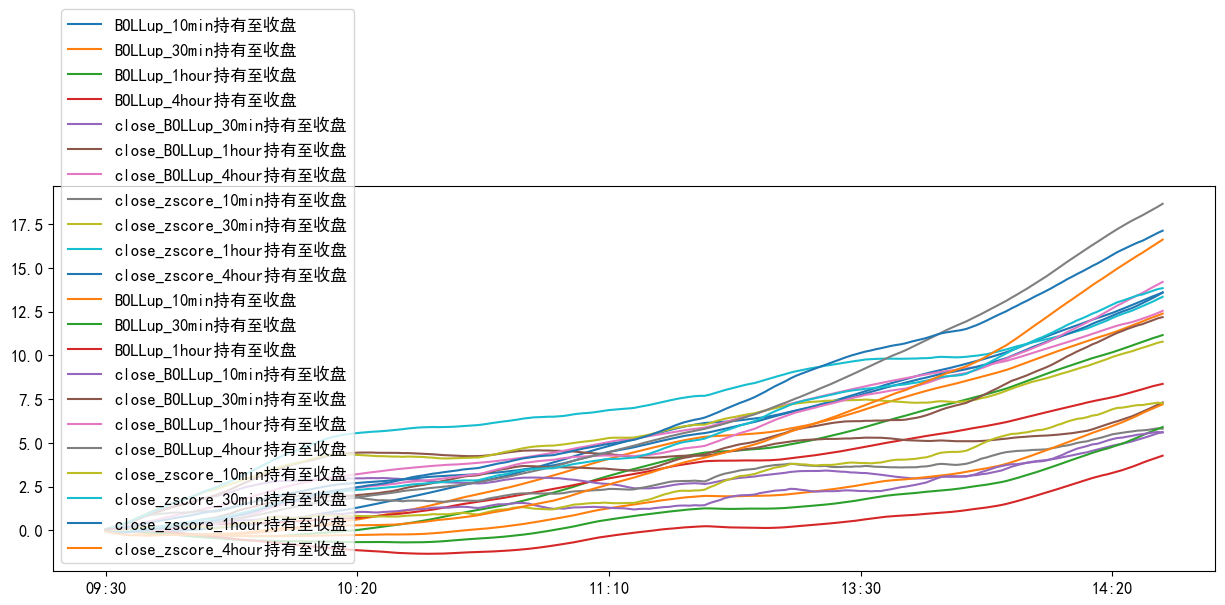

In [82]:
factor_list = ['BOLLup_10min','BOLLup_30min','BOLLup_1hour','BOLLup_4hour',
               'close_BOLLup_10min','close_BOLLup_30min','close_BOLLup_1hour','close_BOLLup_4hour',
               'close_zscore_10min','close_zscore_30min','close_zscore_1hour','close_zscore_4hour']

def BOLL_factor(minquote):
    minquote.loc[:,'BOLLup_10min'] = minquote['close'].rolling(10,min_periods=5).mean()+2*minquote['close'].rolling(10,min_periods=5).std()
    minquote.loc[:,'BOLLup_30min'] = minquote['close'].rolling(30,min_periods=15).mean()+2*minquote['close'].rolling(30,min_periods=15).std()
    minquote.loc[:,'BOLLup_1hour'] = minquote['close'].rolling(60,min_periods=30).mean()+2*minquote['close'].rolling(60,min_periods=30).std()
    minquote.loc[:,'BOLLup_4hour'] = minquote['close'].rolling(240,min_periods=120).mean()+2*minquote['close'].rolling(240,min_periods=120).std()
    minquote.loc[:,'close_BOLLup_10min'] = minquote['close']/minquote.loc[:,'BOLLup_10min']
    minquote.loc[:,'close_BOLLup_30min'] = minquote['close']/minquote.loc[:,'BOLLup_30min']
    minquote.loc[:,'close_BOLLup_1hour'] = minquote['close']/minquote.loc[:,'BOLLup_1hour']
    minquote.loc[:,'close_BOLLup_4hour'] = minquote['close']/minquote.loc[:,'BOLLup_4hour']
    minquote.loc[:,'close_zscore_10min'] = (minquote['close']-minquote['close'].rolling(10,min_periods=5).mean())/minquote['close'].rolling(10,min_periods=5).std()
    minquote.loc[:,'close_zscore_30min'] = (minquote['close']-minquote['close'].rolling(30,min_periods=15).mean())/minquote['close'].rolling(30,min_periods=15).std()
    minquote.loc[:,'close_zscore_1hour'] = (minquote['close']-minquote['close'].rolling(60,min_periods=30).mean())/minquote['close'].rolling(60,min_periods=30).std()
    minquote.loc[:,'close_zscore_4hour'] = (minquote['close']-minquote['close'].rolling(240,min_periods=120).mean())/minquote['close'].rolling(240,min_periods=120).std()
    return minquote

FactorIC_ = FactorIC(rolling_window = 1200)
FactorIC_.CalcFactors(BOLL_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 86.830345 分钟
胜率：0.384831
年化收益率：0.324667
年化夏普比率：2.068107


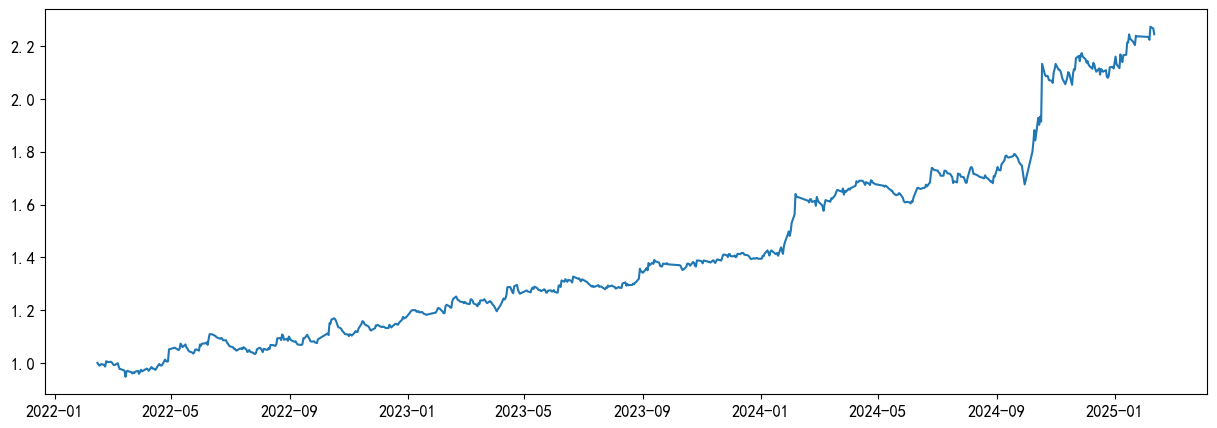

In [17]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'close_BOLLup_4hour',
    direction = 1,
    periods = [('09:59','10:59'),('13:29','14:29')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.6,
    lower_stop_bound = 0.4,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.11 西部的上下限突破因子 *

F159915: close_upper_bound: 持有至收盘 IC: 0.110, IR: 3.684
F159915: close_lower_bound: 持有至收盘 IC: 0.138, IR: 5.366
F588080: upper_bound: 持有至收盘 IC: -0.046, IR: -2.550
F588080: lower_bound: 持有至收盘 IC: -0.037, IR: -1.571
F588080: close_upper_bound: 持有至收盘 IC: 0.133, IR: 2.804
F588080: close_lower_bound: 持有至收盘 IC: 0.117, IR: 2.234


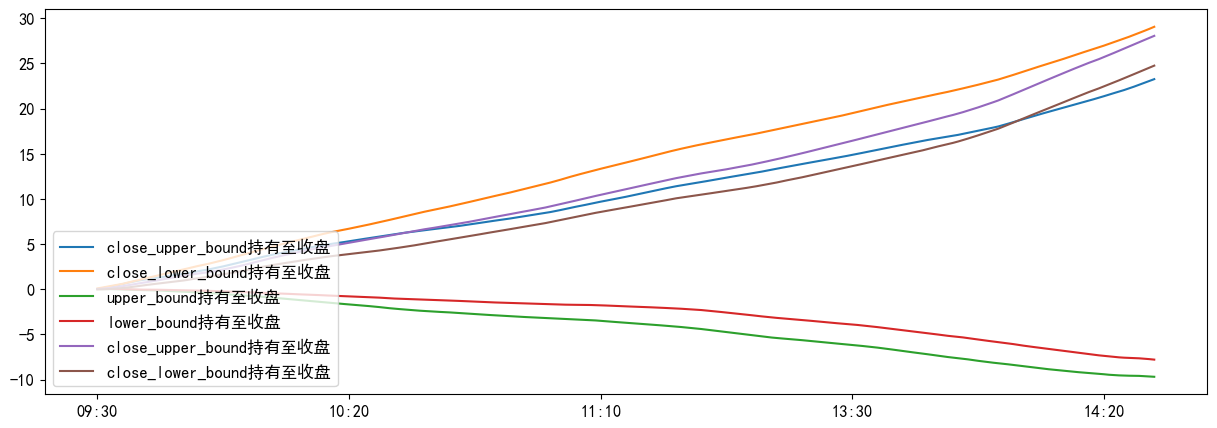

In [83]:
factor_list = ['upper_bound','lower_bound','close_upper_bound','close_lower_bound']

def GetMomBound_factor(minquote):
    """计算动量策略的上下限"""
    minquote.loc[:,'open0930'] = minquote.groupby(minquote.index.date)['open'].transform(lambda x: x.iloc[0])  # 0930开盘价
    minquote.loc[:,'move'] = (minquote['close']/minquote['open0930']-1).abs()  # 计算每分钟的价格位移
    minquote.loc[:,'move_rolling10'] = minquote.groupby(minquote.index.strftime('%H:%M'))['move'].transform(lambda x: x.rolling(10,min_periods=5).mean())
    minquote.loc[:,'close_last'] = (minquote.groupby(minquote.index.date)['close'].transform(lambda x: x.iloc[-1])).shift(240)  # 前一日收盘价
    minquote.loc[:,'upper_bound'] = minquote[['open0930','close_last']].max(axis=1)*(1+minquote['move_rolling10'])  # 计算上限
    minquote.loc[:,'lower_bound'] = minquote[['open0930','close_last']].min(axis=1)*(1-minquote['move_rolling10'])  # 计算下限
    minquote.loc[:,'close_upper_bound'] = minquote['close']/minquote['upper_bound']
    minquote.loc[:,'close_lower_bound'] = minquote['close']/minquote['lower_bound']
    return minquote

FactorIC_ = FactorIC(rolling_window=1200)
FactorIC_.CalcFactors(GetMomBound_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 121.26 分钟
平均每日交易次数: 0.96
胜率：0.49
年化收益率：0.705
年化波动率：0.166
年化夏普比率：4.243
最大回撤: 0.081
Calmar比率: 8.761


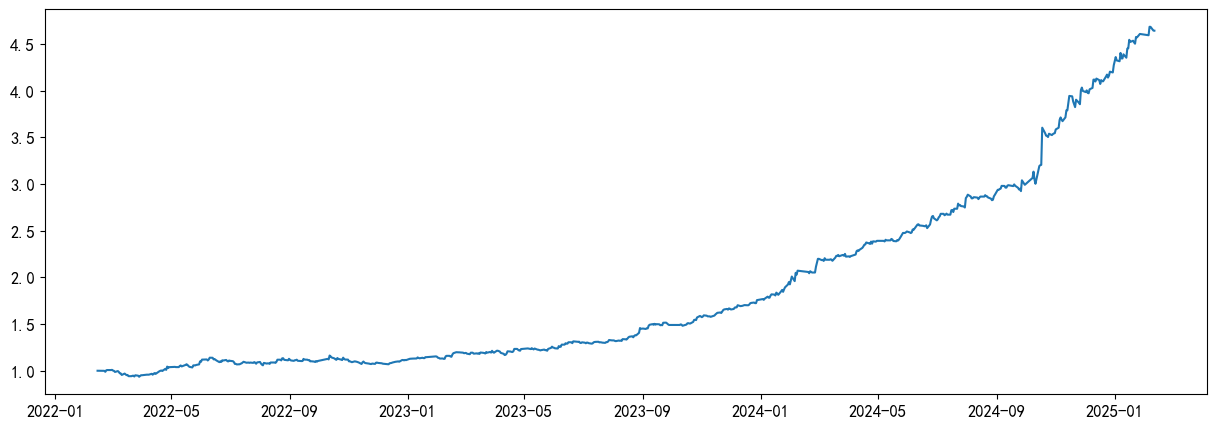

In [7]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'close_upper_bound',
    direction = 1,
    periods = [('10:00','14:50')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.5,
    lower_stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.12 能量潮 ADL *

F159915: ADL_10min: 持有至收盘 IC: 0.035, IR: 0.707
F159915: ADL_1hour: 持有至收盘 IC: 0.063, IR: 1.270
F159915: ADL_4hour: 持有至收盘 IC: 0.068, IR: 2.573
F588080: ADL_10min: 持有至收盘 IC: 0.045, IR: 1.117
F588080: ADL_1hour: 持有至收盘 IC: 0.082, IR: 3.625
F588080: ADL_4hour: 持有至收盘 IC: 0.079, IR: 1.510


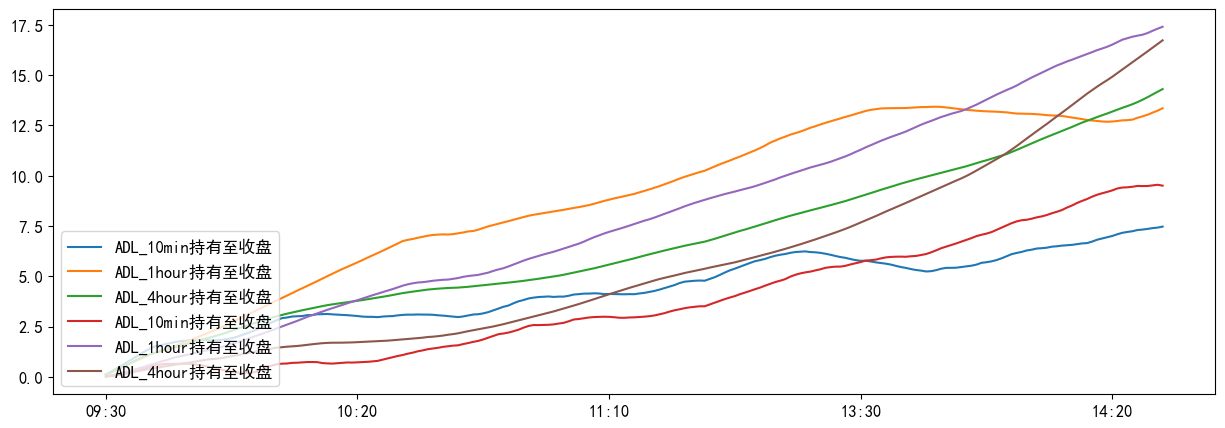

In [84]:
factor_list = ['ADL_10min','ADL_1hour','ADL_4hour']
def ADL_factor(minquote):
    minquote.loc[:,'ret_min'] = minquote['close']/minquote['open']-1
    minquote.loc[:,'ADL'] = minquote['ret_min']*minquote['volume']
    minquote.loc[:,'ADL_10min'] = minquote['ADL'].rolling(10,min_periods=5).mean()
    minquote.loc[:,'ADL_1hour'] = minquote['ADL'].rolling(60,min_periods=30).mean()
    minquote.loc[:,'ADL_4hour'] = minquote['ADL'].rolling(240,min_periods=120).mean()
    return minquote

FactorIC_ = FactorIC(rolling_window=1200)
FactorIC_.CalcFactors(ADL_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

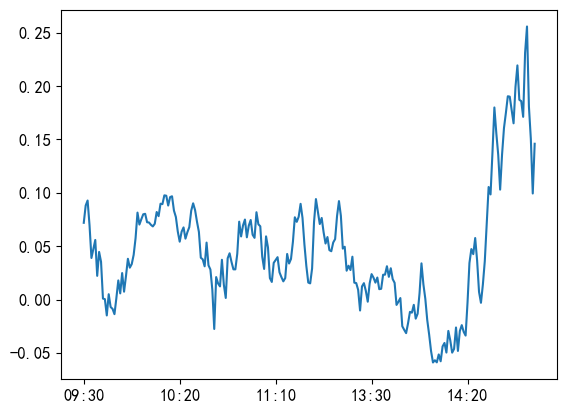

In [36]:
temp_minquote_F159915 = FactorIC_.minquotes['F159915'].loc[FactorIC_.minquotes['F159915'].index.date<=pd.to_datetime('2023-02-11').date()]
temp_minquote_F159915.loc[:,'ADL_1hour'] = temp_minquote_F159915['ADL_1hour'].rolling(1200,min_periods=240).rank(pct=True)
F159915_ADL_1hour_IC = temp_minquote_F159915.groupby(temp_minquote_F159915.index.strftime('%H:%M')).apply(lambda x: x['ADL_1hour'].corr(x['htc_ret'])).sort_index()
F159915_ADL_1hour_IC.plot()
F159915_ADL_1hour_IC.to_excel('output/F159915_ADL_1hour_IC.xlsx')

<Axes: >

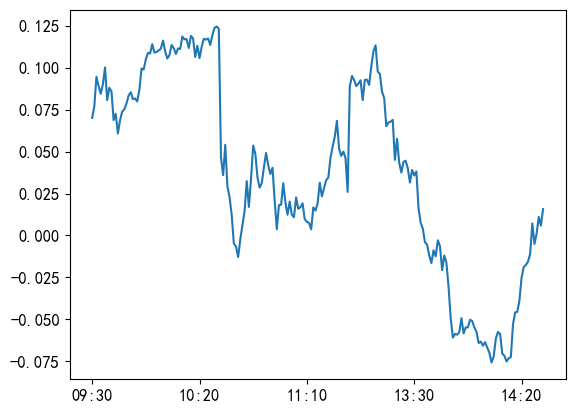

In [12]:
FactorIC_.ICresult['F159915']['ADL_1hour'].plot()

平均持仓时间: 84.14 分钟
平均每日交易次数: 0.99
胜率：0.51
平均单次盈利: 0.007
平均单次亏损: -0.004
平均单次盈利/亏损: 1.694
年化收益率：0.470
年化波动率：0.137
年化夏普比率：3.440
最大回撤: 0.071
Calmar比率: 6.646


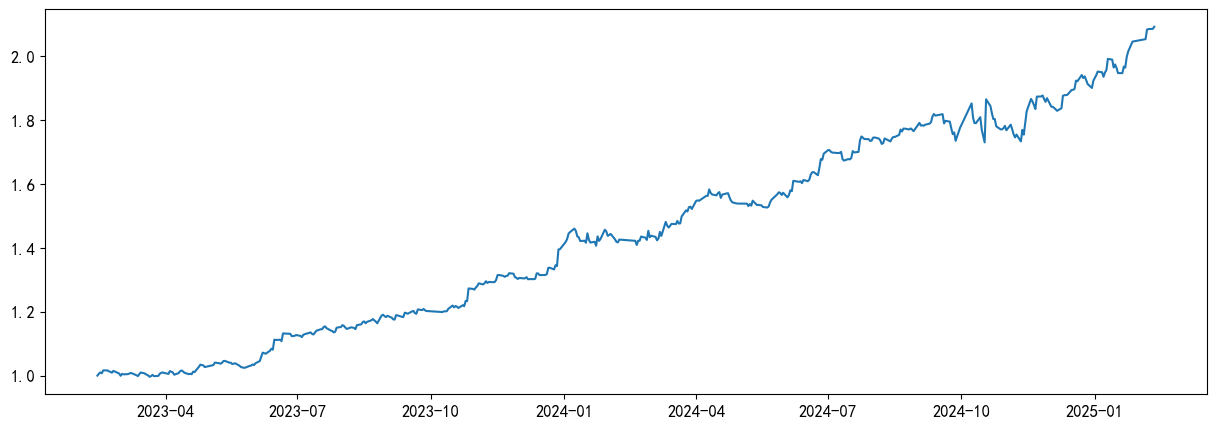

In [43]:

strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F159915'],
    factor_name = 'ADL_1hour',
    direction = 1,
    start_date= '2023-02-11',
    periods = [('09:30','14:50')],
    rolling_is_rank = True,
    rolling_window = 1200,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.4,
    lower_stop_bound = 0.6,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()
daily_performance.to_excel('output/F159915_ADL_1hour_daily_performance_0.xlsx')

平均持仓时间: 98.09 分钟
平均每日交易次数: 0.98
胜率：0.51
平均单次盈利: 0.008
平均单次亏损: -0.004
平均单次盈利/亏损: 1.928
年化收益率：0.686
年化波动率：0.148
年化夏普比率：4.622
最大回撤: 0.075
Calmar比率: 9.084


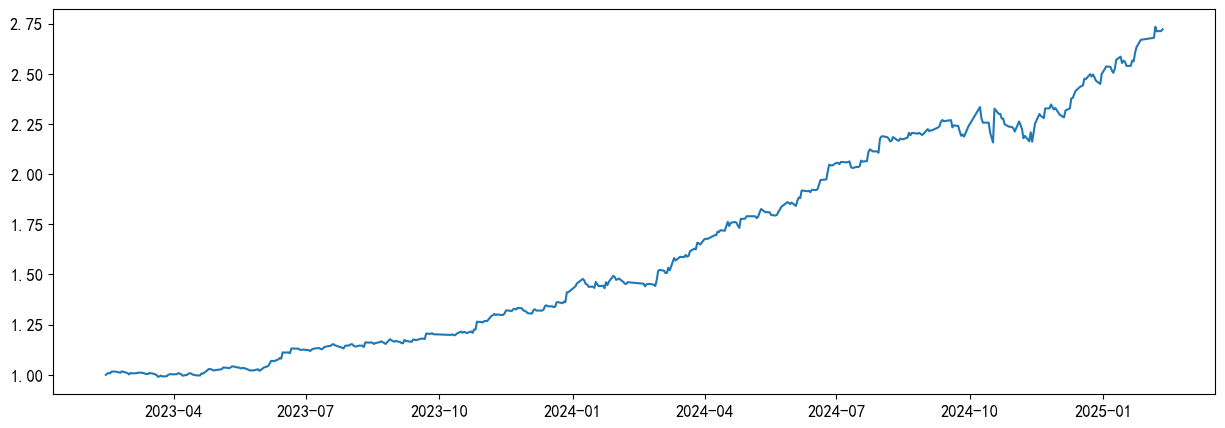

In [44]:
## 定义因子有效期
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F159915'],
    factor_name = 'ADL_1hour',
    direction = 1,
    start_date= '2023-02-11',
    periods = [('09:29','13:00'),('14:30','14:55')],
    rolling_is_rank = True,
    rolling_window = 1200,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.4,
    lower_stop_bound = 0.6,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()
daily_performance.to_excel('output/F159915_ADL_1hour_daily_performance_1.xlsx')

平均持仓时间: 78.092414 分钟
胜率：0.491597
年化收益率：0.544757
年化夏普比率：3.653910


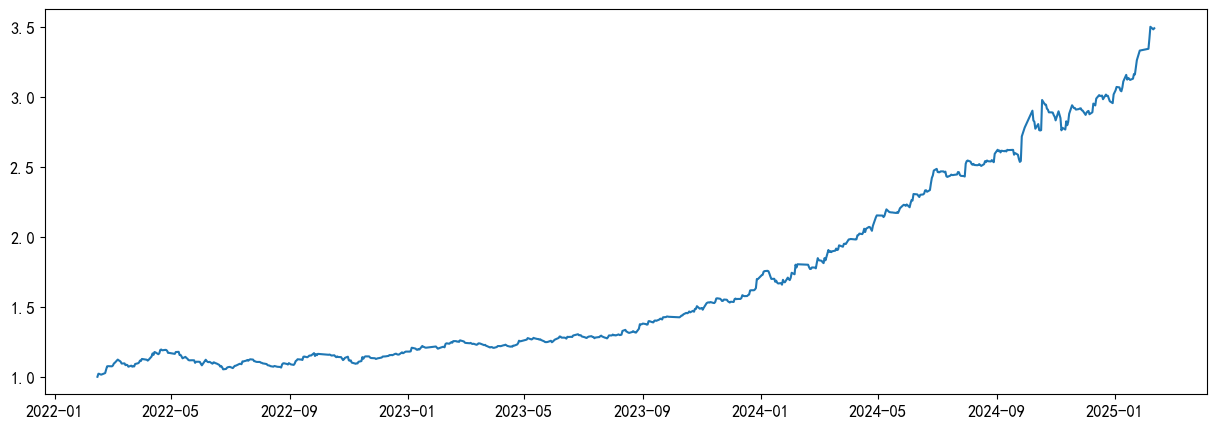

In [ ]:

strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F159915'],
    factor_name = 'ADL_1hour',
    direction = 1,
    start_date= '2023-02-11'
    periods = [('09:29','12:50')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.5,
    lower_stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.13 收益率高阶矩

F159915: ret_std_10min: 持有至收盘 IC: 0.025, IR: 0.858
F159915: ret_std_1hour: 持有至收盘 IC: 0.042, IR: 1.876
F159915: ret_skew_4hour: 持有至收盘 IC: 0.059, IR: 4.164
F159915: ret_kurt_4hour: 持有至收盘 IC: 0.025, IR: 1.406
F588080: ret_std_4hour: 持有至收盘 IC: -0.027, IR: -1.438


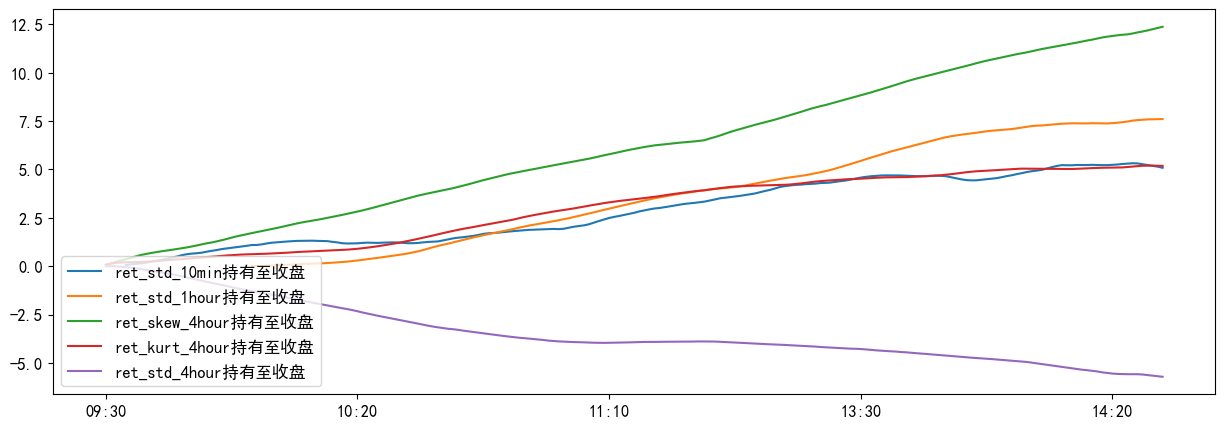

In [36]:
factor_list = ['ret_std_10min','ret_std_1hour','ret_std_4hour','ret_std_10min_1hour',
               'ret_skew_10min','ret_skew_1hour','ret_skew_4hour','ret_skew_10min_1hour',
               'ret_kurt_10min','ret_kurt_1hour','ret_kurt_4hour','ret_kurt_10min_1hour']
def ret_factor(minquote):
    minquote.loc[:,'ret_min'] = minquote['close']/minquote['open']-1
    minquote.loc[:,'ret_std_10min'] = minquote['ret_min'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).std())
    minquote.loc[:,'ret_std_1hour'] = minquote['ret_min'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).std())
    minquote.loc[:,'ret_std_4hour'] = minquote['ret_min'].rolling(240,min_periods=120).std()
    minquote.loc[:,'ret_std_10min_1hour'] = minquote['ret_std_10min']/minquote['ret_std_1hour']
    minquote.loc[:,'ret_skew_10min'] = minquote['ret_min'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).skew())
    minquote.loc[:,'ret_skew_1hour'] = minquote['ret_min'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).skew())
    minquote.loc[:,'ret_skew_4hour'] = minquote['ret_min'].rolling(240,min_periods=120).skew()
    minquote.loc[:,'ret_skew_10min_1hour'] = minquote['ret_skew_10min']/minquote['ret_skew_1hour']
    minquote.loc[:,'ret_kurt_10min'] = minquote['ret_min'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).kurt())
    minquote.loc[:,'ret_kurt_1hour'] = minquote['ret_min'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).kurt())
    minquote.loc[:,'ret_kurt_4hour'] = minquote['ret_min'].rolling(240,min_periods=120).kurt()
    minquote.loc[:,'ret_kurt_10min_1hour'] = minquote['ret_kurt_10min']/minquote['ret_kurt_1hour']
    return minquote
FactorIC_ = FactorIC(rolling_window=480)
FactorIC_.CalcFactors(ret_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

<Axes: >

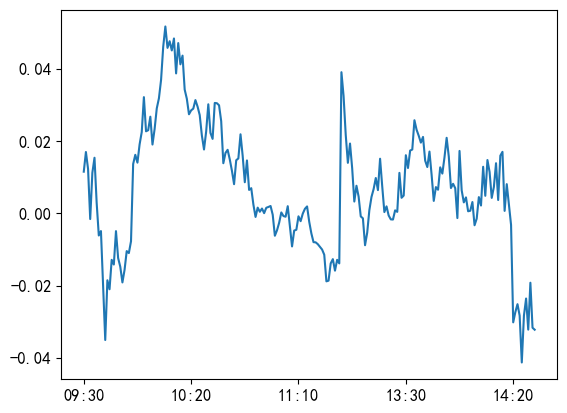

In [37]:
FactorIC_.ICresult['F588080']['ret_skew_4hour'].plot()

平均持仓时间: 139.728276 分钟
胜率：0.516923
年化收益率：0.042150
年化夏普比率：0.263976


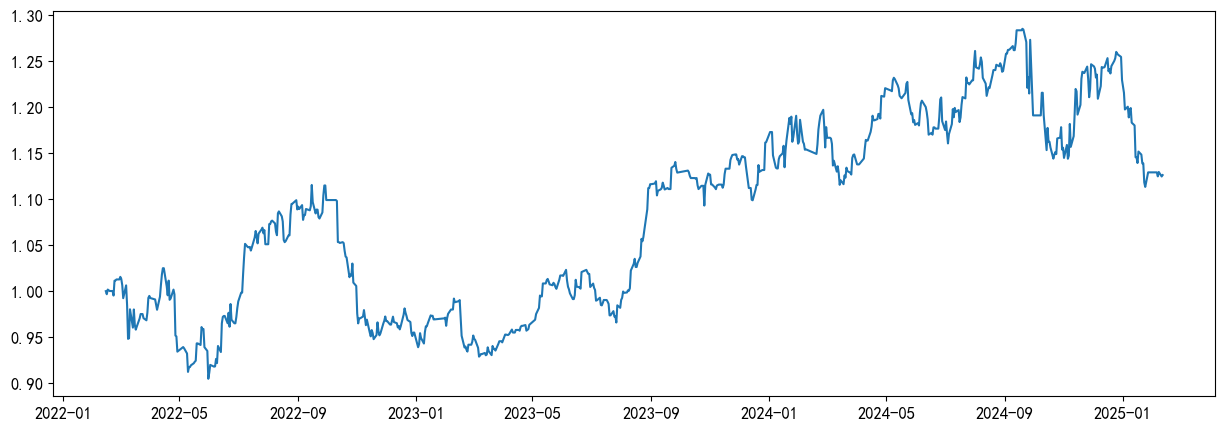

In [39]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F159915'],
    factor_name = 'ret_skew_4hour',
    direction = 1,
    periods = [('09:59','13:59')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.5,
    lower_stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.14 实体动量占比

F159915: CMO_HML_10min: 持有至收盘 IC: 0.006, IR: 0.177
F159915: CMO_HML_1hour: 持有至收盘 IC: 0.003, IR: 0.074
F159915: CMO_HML_4hour: 持有至收盘 IC: -0.008, IR: -0.297
F159915: CMO_HML_10min_1hour: 持有至收盘 IC: 0.002, IR: 0.054
F588080: CMO_HML_10min: 持有至收盘 IC: 0.002, IR: 0.071
F588080: CMO_HML_1hour: 持有至收盘 IC: 0.005, IR: 0.169
F588080: CMO_HML_4hour: 持有至收盘 IC: -0.005, IR: -0.348
F588080: CMO_HML_10min_1hour: 持有至收盘 IC: -0.004, IR: -0.109


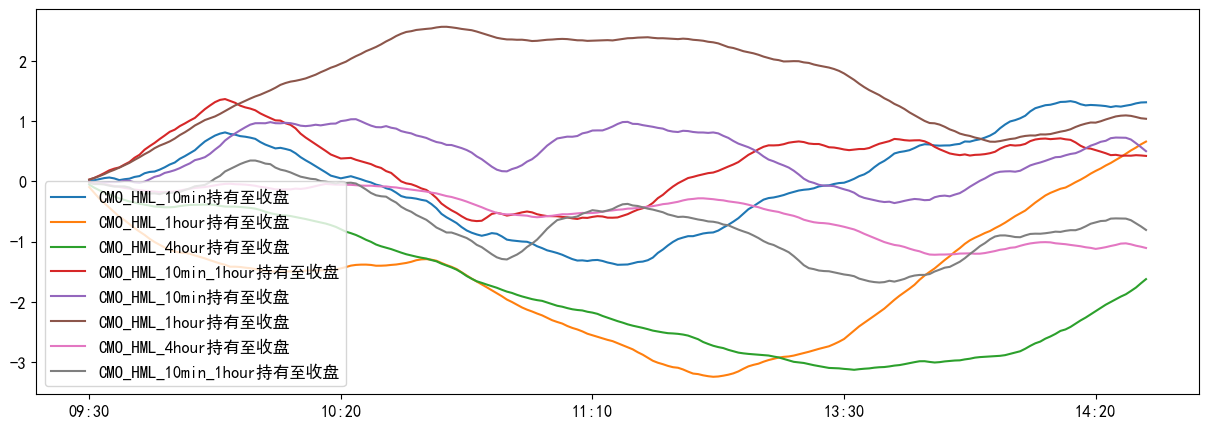

In [ ]:
# 上下影线太多为0，所以不能求比值，求差
factor_list = ['CMO_HML_10min','CMO_HML_1hour','CMO_HML_4hour','CMO_HML_10min_1hour',
               'CMO_growth_10min','CMO_growth_1hour','CMO_growth_4hour']

def solidmom_factor(minquote):
    
    minquote.loc[:,'CMO_HML'] = (minquote['close']-minquote['open'])/(minquote['high']-minquote['low'])
    minquote.loc[:,'CMO_HML_10min'] = minquote['CMO_HML'].rolling(10,min_periods=5).mean()
    minquote.loc[:,'CMO_HML_1hour'] = minquote['CMO_HML'].rolling(60,min_periods=30).mean()
    minquote.loc[:,'CMO_HML_4hour'] = minquote['CMO_HML'].rolling(240,min_periods=120).mean()
    minquote.loc[:,'CMO_HML_10min_1hour'] = minquote['CMO_HML_10min']/minquote['CMO_HML_1hour']
    
    minquote.loc[:,'CMO'] = minquote['close']-minquote['open']
    minquote.loc[:,'CMO_growth_10min'] = minquote['CMO']/minquote['CMO'].rolling(10,min_periods=5).mean()
    minquote.loc[:,'CMO_growth_1hour'] = minquote['CMO']/minquote['CMO'].rolling(60,min_periods=30).mean()
    minquote.loc[:,'CMO_growth_4hour'] = minquote['CMO']/minquote['CMO'].rolling(240,min_periods=120).mean()
    return minquote

FactorIC_ = FactorIC()
FactorIC_.CalcFactors(solidmom_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)


In [ ]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'ret_volume_corr_4hour',
    direction = 1,
    periods = [('09:59','14:50')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.6,
    lower_stop_bound = 0.4,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

### 3.2 根据过去一年的IC进行加权的因子效果

In [34]:
## 总结所有的因子及其相关性测试
final_factor_list = ['amihud_mean_10min',
                     'amihud_vwap_corr_1hour',
                     'HML_vwap_corr_4hour',
                     'HMC_CML_mean_4hour',
                     'ret_volume_corr_4hour',
                     'RSI_1hour',
                     'MACD_1hour_4hour',
                     'close_BOLLup_4hour',
                     'close_upper_bound',
                     'ADL_1hour'
                     ]
def CalcFinalFactors(minquote):
    # 因子一：amihud 10分钟均值 * -1
    minquote.loc[:,'ret_min_abs'] = (minquote['close']/minquote['open']-1).abs()
    minquote.loc[:,'amihud'] = minquote['ret_min_abs']/minquote['amount']
    minquote.loc[:,'amihud_mean_10min'] = -(minquote['amihud']).rolling(10,min_periods=5).mean()
    
    # 因子二：amihud 与 vwap 的一小时相关系数 * -1
    minquote.loc[:,'vwap'] = minquote['amount'] / minquote['volume']
    minquote.loc[:,'amihud_vwap_corr_1hour'] = -minquote['amihud'].rolling(60,min_periods=30).corr(minquote['vwap'])

    # 因子三：振幅与 vwap 的四小时相关系数 * -1
    minquote.loc[:,'HML'] = minquote['high']/minquote['low']-1
    minquote.loc[:,'HML_vwap_corr_4hour'] = -minquote['HML'].rolling(240,min_periods=120).corr(minquote['vwap'])

    # 因子四：上下影线差的四小时均值 * -1
    minquote.loc[:,'HMC_CML'] = (minquote['high']-minquote['close'])-(minquote['close']-minquote['low'])
    minquote.loc[:,'HMC_CML_mean_4hour'] = -minquote['HMC_CML'].rolling(240,min_periods=120).mean()

    # 因子五：收益率与成交量4小时相关系数 * 1
    minquote.loc[:,'volume_ratio'] = minquote['volume']/minquote['volume'].rolling(480,min_periods=60).mean()
    minquote.loc[:,'ret_min'] = minquote['close']/minquote['open']-1
    minquote.loc[:,'ret_volume_corr_4hour'] = minquote['ret_min'].rolling(240,min_periods=120).corr(minquote['volume_ratio'])

    # 因子六：1小时RSI * 1
    minquote.loc[:,'close_diff'] = minquote['close'] - minquote['close'].shift(1)
    minquote.loc[:,'RSI_1hour'] = -(minquote['close_diff']*(minquote['close_diff'] > 0)).rolling(60,min_periods=30).mean() / (minquote['close_diff']*(minquote['close_diff'] < 0)).rolling(60,min_periods=30).mean()
    
    # 因子七：MACD指标 * 1
    minquote.loc[:,'EMA_1hour'] = minquote['close'].ewm(span=60,min_periods=30).mean()
    minquote.loc[:,'EMA_4hour'] = minquote['close'].ewm(span=240,min_periods=120).mean()
    minquote.loc[:,'MACD_1hour_4hour'] = minquote['EMA_1hour'] - minquote['EMA_4hour']

    # 因子八：收盘价比上4小时布林带上界 * 1
    minquote.loc[:,'BOLLup_4hour'] = minquote['close'].rolling(240,min_periods=120).mean()+2*minquote['close'].rolling(240,min_periods=120).std()
    minquote.loc[:,'close_BOLLup_4hour'] = minquote['close']/minquote.loc[:,'BOLLup_4hour']

    # 因子九：西部证券的上限突破因子
    minquote.loc[:,'open0930'] = minquote.groupby(minquote.index.date)['open'].transform(lambda x: x.iloc[0])  # 0930开盘价
    minquote.loc[:,'move'] = (minquote['close']/minquote['open0930']-1).abs()  # 计算每分钟的价格位移
    minquote.loc[:,'move_rolling10'] = minquote.groupby(minquote.index.strftime('%H:%M'))['move'].transform(lambda x: x.rolling(10,min_periods=5).mean())
    minquote.loc[:,'close_last'] = (minquote.groupby(minquote.index.date)['close'].transform(lambda x: x.iloc[-1])).shift(240)  # 前一日收盘价
    minquote.loc[:,'upper_bound'] = minquote[['open0930','close_last']].min(axis=1)*(1+minquote['move_rolling10'])  # 计算下限
    minquote.loc[:,'close_upper_bound'] = minquote['close']/minquote['upper_bound']
    
    # 因子十：一小时能量潮ADL因子
    minquote.loc[:,'ret_min'] = minquote['close']/minquote['open']-1
    minquote.loc[:,'ADL'] = minquote['ret_min']*minquote['volume']
    minquote.loc[:,'ADL_1hour'] = minquote['ADL'].rolling(60,min_periods=30).mean()
    
    return minquote

FactorIC_ = FactorIC()
FactorIC_.CalcFactors(CalcFinalFactors)  #计算因子值
factors = FactorIC_.minquotes

start_time = '10:00'
end_time = '14:50'

rolling_window = 240*5
IC_weight = {'F588080': pd.DataFrame(index=factors['F588080'].index), 'F159915': pd.DataFrame(index=factors['F159915'].index)}
for FundCode in ['F588080','F159915']:
    for factor_name in final_factor_list:
        IC_weight[FundCode].loc[:,factor_name] = factors[FundCode].groupby(factors[FundCode].index.strftime('%H:%M')).apply(lambda x: x[factor_name].rolling(240,min_periods = 120).corr(x['htc_ret']).shift()).droplevel(0).sort_index() #计算过去一年时间的择时IC
        # factors[FundCode].loc[(factors[FundCode].index.strftime('%H:%M')<start_time)|(factors[FundCode].index.strftime('%H:%M')>end_time), factor_name] = np.nan
        factors[FundCode].loc[:,factor_name] = factors[FundCode].loc[:,factor_name].rolling(rolling_window,min_periods=240).rank(pct=True)

for FundCode in ['F588080','F159915']:
    IC_weight[FundCode] = IC_weight[FundCode].map(lambda x: 0 if x<0 else x).apply(lambda x: x/x.sum(),axis=1)  # 因子IC线性加权
    #IC_weight[FundCode] = IC_weight[FundCode].apply(lambda x: np.exp(x)/np.exp(x).sum(),axis=1)
    IC_weight[FundCode] = IC_weight[FundCode]*factors[FundCode][final_factor_list]
    factors[FundCode].loc[:,'IC_weighted_factor'] = IC_weight[FundCode].sum(axis=1)

In [35]:
IC1 = factors['F588080'].groupby(factors['F588080'].index.strftime('%H:%M')).apply(lambda x:x['IC_weighted_factor'].corr(x['htc_ret']))
IC2 = factors['F159915'].groupby(factors['F588080'].index.strftime('%H:%M')).apply(lambda x:x['IC_weighted_factor'].corr(x['htc_ret']))
print(f'F588080的IC为{IC1.mean(): .3f},IR为{IC1.mean()/IC1.std(): .3f}')
print(f'F159915的IC为{IC2.mean(): .3f},IR为{IC2.mean()/IC2.std(): .3f}')
IC_weighted = pd.DataFrame([IC1,IC2]).T
IC_weighted.to_excel('output/IC_weighted.xlsx')
IC1.plot()
IC2.plot()  

F588080的IC为 0.078,IR为 1.446
F159915的IC为 0.085,IR为 2.693


OSError: Cannot save file into a non-existent directory: 'output'

平均持仓时间: 91.91 分钟
平均每日交易次数: 0.78
胜率：0.55
平均单次盈利: 0.009
平均单次亏损: -0.005
平均单次盈利/亏损: 1.873
年化收益率：0.720
年化波动率：0.170
年化夏普比率：4.245
最大回撤: 0.052
Calmar比率: 13.852


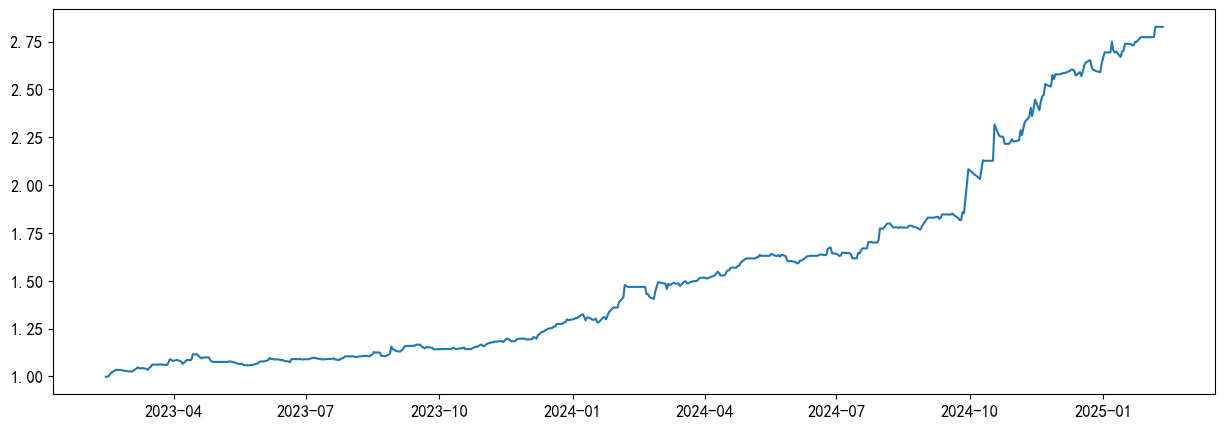

In [6]:
strategy = ETFIntradayStrategy(
    data=factors['F588080'],
    factor_name = 'IC_weighted_factor',
    direction = 1,
    start_date = '2023-02-12',
    end_date = '2025-02-11',
    periods = [('10:00','14:55')],
    rolling_is_rank = True,
    rolling_window = 1200,
    bound_is_series = True,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.4,
    lower_stop_bound = 0.6,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

平均持仓时间: 92.31 分钟
平均每日交易次数: 0.78
胜率：0.55
平均单次盈利: 0.009
平均单次亏损: -0.005
平均单次盈利/亏损: 1.861
年化收益率：0.731
年化波动率：0.170
年化夏普比率：4.305
最大回撤: 0.052
Calmar比率: 14.073


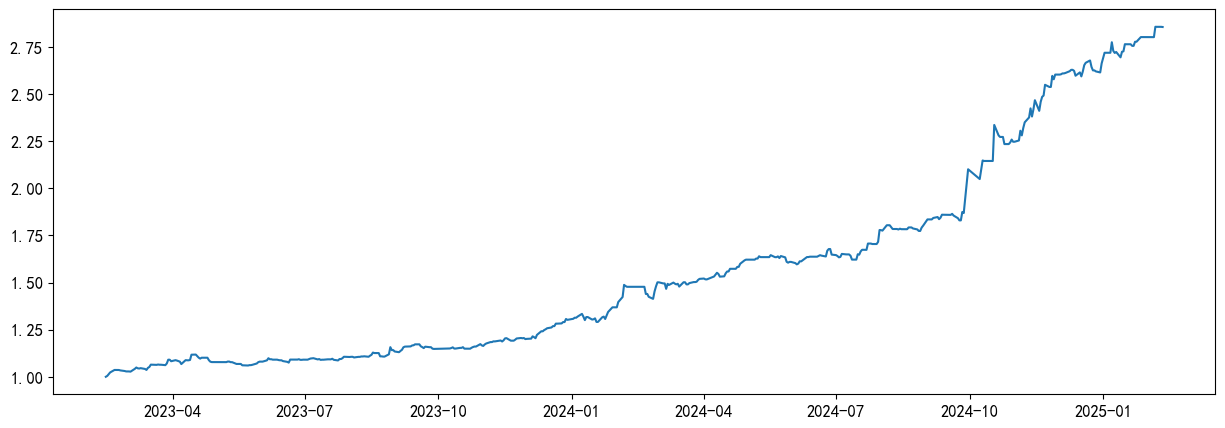

In [21]:
## 有略微的提升
start_time = '10:00'
end_time = '14:55'
upper_quantile = 0.8
lower_quantile = 0.2
upper_stop_quantile = 0.6
lower_stop_quantile = 0.4
FinalFactorIC = factors['F588080'].groupby(factors['F588080'].index.strftime('%H:%M')).apply(lambda x: x['IC_weighted_factor'].rolling(120,min_periods=60).corr(x['htc_ret']).shift()).droplevel(0).sort_index()
FinalFactorIC = FinalFactorIC.apply(lambda x: 0 if x<0 else x).fillna(0)
FinalFactorIC.loc[(FinalFactorIC.index.strftime('%H:%M')<start_time)|(FinalFactorIC.index.strftime('%H:%M')>end_time)] = 0
upper_bound = FinalFactorIC.groupby(FinalFactorIC.index.date).transform(lambda x: upper_quantile-0.2*x/x.sum())
lower_bound = FinalFactorIC.groupby(FinalFactorIC.index.date).transform(lambda x: lower_quantile+0.2*x/x.sum())
#upper_stop_bound = FinalFactorIC.groupby(FinalFactorIC.index.date).transform(lambda x: upper_stop_quantile+0.2*x/x.sum())
#lower_stop_bound = FinalFactorIC.groupby(FinalFactorIC.index.date).transform(lambda x: lower_stop_quantile-0.2*x/x.sum())

strategy = ETFIntradayStrategy(
    data=factors['F588080'],
    factor_name = 'IC_weighted_factor',
    direction = 1,
    start_date = '2023-02-14',
    end_date = '2025-02-11',
    periods = [('10:00','14:55')],
    rolling_is_rank = True,
    rolling_window = 1200,
    bound_is_series = True,
    upper_bound = upper_bound,
    lower_bound = lower_bound,
    upper_stop_bound = upper_stop_bound,
    lower_stop_bound = lower_stop_bound,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()
daily_performance.to_excel('output/F588080_weightedfactor_performance.xlsx')

平均持仓时间: 98.99 分钟
平均每日交易次数: 0.78
胜率：0.55
平均单次盈利: 0.008
平均单次亏损: -0.005
平均单次盈利/亏损: 1.687
年化收益率：0.536
年化波动率：0.136
年化夏普比率：3.943
最大回撤: 0.051
Calmar比率: 10.554


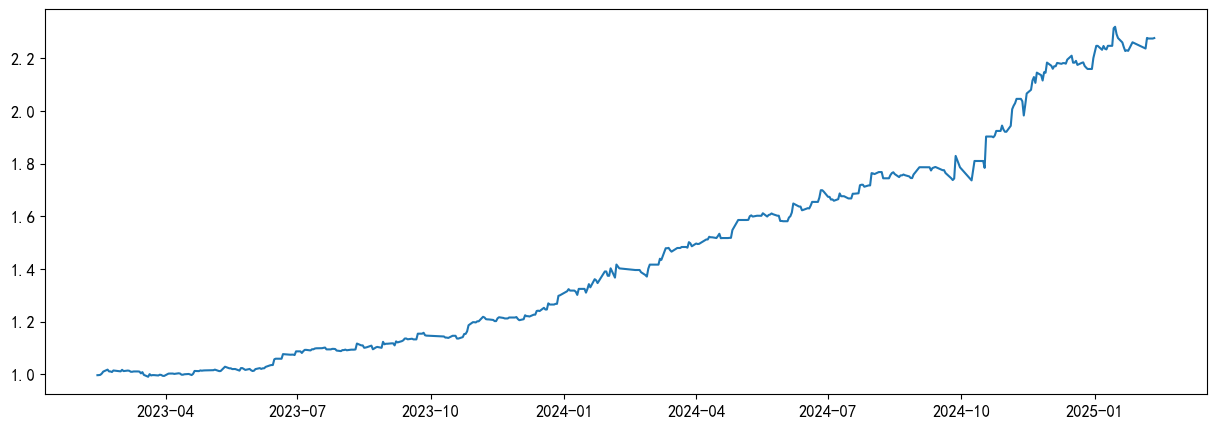

In [8]:
strategy = ETFIntradayStrategy(
    data=factors['F159915'],
    factor_name = 'IC_weighted_factor',
    direction = 1,
    start_date = '2023-02-12',
    end_date = '2025-02-11',
    periods = [('10:00','14:55')],
    rolling_is_rank = True,
    rolling_window = 1200,
    bound_is_series = True,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.4,
    lower_stop_bound = 0.6,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

平均持仓时间: 99.24 分钟
平均每日交易次数: 0.79
胜率：0.55
平均单次盈利: 0.008
平均单次亏损: -0.005
平均单次盈利/亏损: 1.689
年化收益率：0.547
年化波动率：0.136
年化夏普比率：4.017
最大回撤: 0.051
Calmar比率: 10.772


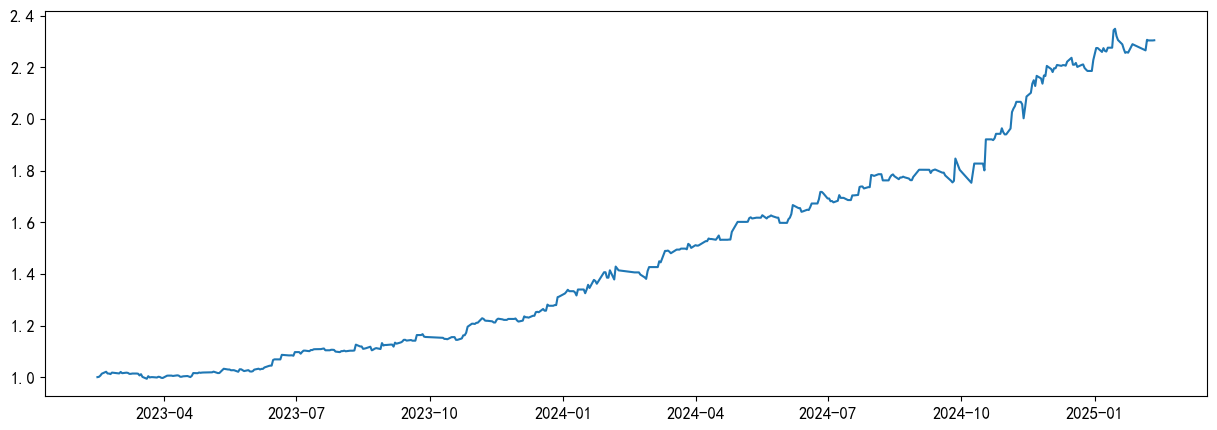

In [20]:
## 有略微的提升
start_time = '10:00'
end_time = '14:55'
upper_quantile = 0.8
lower_quantile = 0.2
upper_stop_quantile = 0.6
lower_stop_quantile = 0.4
FinalFactorIC = factors['F159915'].groupby(factors['F159915'].index.strftime('%H:%M')).apply(lambda x: x['IC_weighted_factor'].rolling(120,min_periods=60).corr(x['htc_ret']).shift()).droplevel(0).sort_index()
FinalFactorIC = FinalFactorIC.apply(lambda x: 0 if x<0 else x).fillna(0)
FinalFactorIC.loc[(FinalFactorIC.index.strftime('%H:%M')<start_time)|(FinalFactorIC.index.strftime('%H:%M')>end_time)] = 0
upper_bound = FinalFactorIC.groupby(FinalFactorIC.index.date).transform(lambda x: upper_quantile-0.2*x/x.sum())
lower_bound = FinalFactorIC.groupby(FinalFactorIC.index.date).transform(lambda x: lower_quantile+0.2*x/x.sum())
#upper_stop_bound = FinalFactorIC.groupby(FinalFactorIC.index.date).transform(lambda x: upper_stop_quantile+0.2*x/x.sum())
#lower_stop_bound = FinalFactorIC.groupby(FinalFactorIC.index.date).transform(lambda x: lower_stop_quantile-0.2*x/x.sum())

strategy = ETFIntradayStrategy(
    data=factors['F159915'],
    factor_name = 'IC_weighted_factor',
    direction = 1,
    start_date = '2023-02-14',
    end_date = '2025-02-11',
    periods = [('10:00','14:55')],
    rolling_is_rank = True,
    rolling_window = 1200,
    bound_is_series = True,
    upper_bound = upper_bound,
    lower_bound = lower_bound,
    upper_stop_bound = upper_stop_bound,
    lower_stop_bound = lower_stop_bound,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()
daily_performance.to_excel('output/F159915_weightedfactor_performance.xlsx')

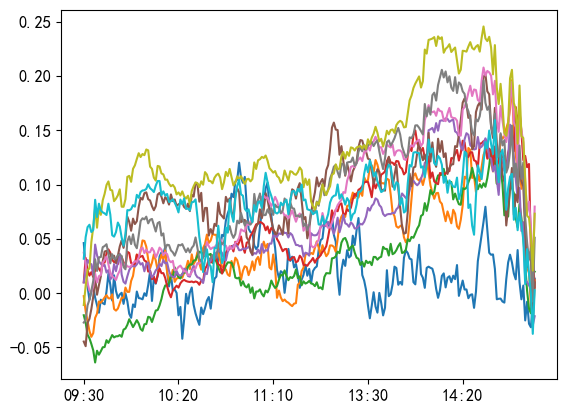

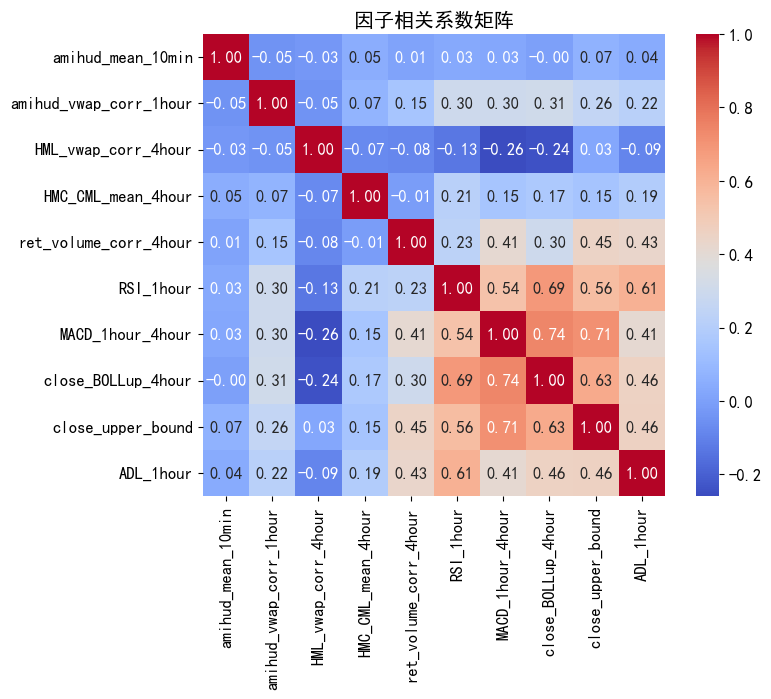

In [4]:
for factor in final_factor_list:
    IC = factors['F588080'].groupby(factors['F588080'].index.strftime("%H:%M")).apply(lambda x:x[f'{factor}'].corr(x['htc_ret']))
    IC.plot()

corr_matrix = factors['F588080'][final_factor_list].corr()
# 创建热力图
plt.figure(figsize=(8, 6))  # 设置图形的大小
heatmap = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('因子相关系数矩阵')
plt.show()

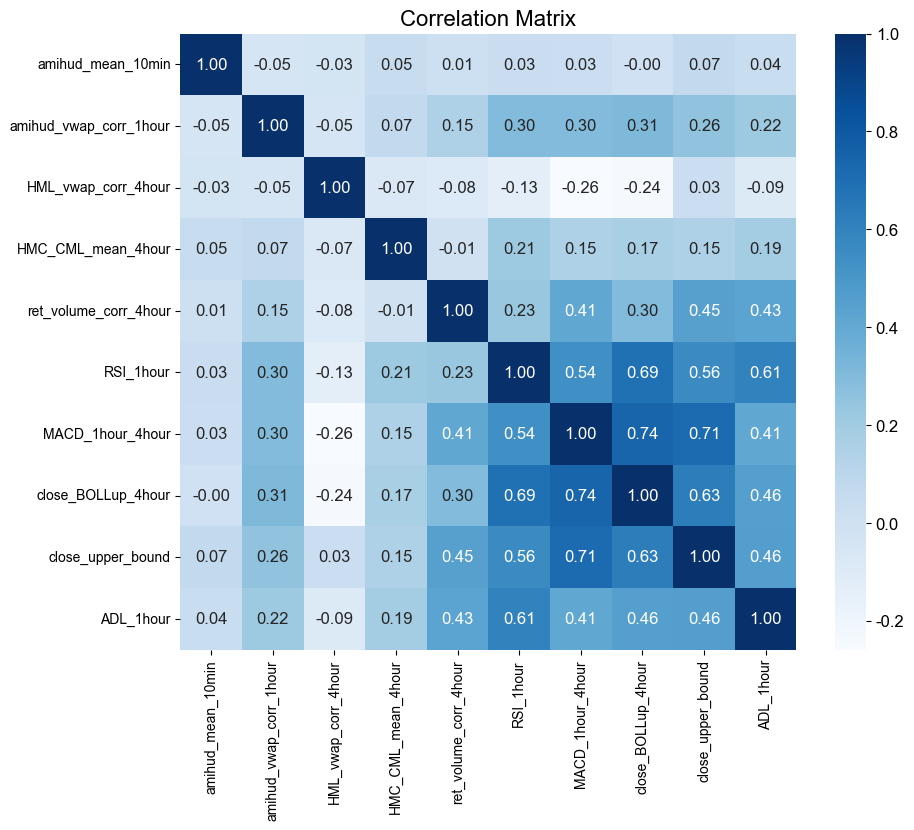

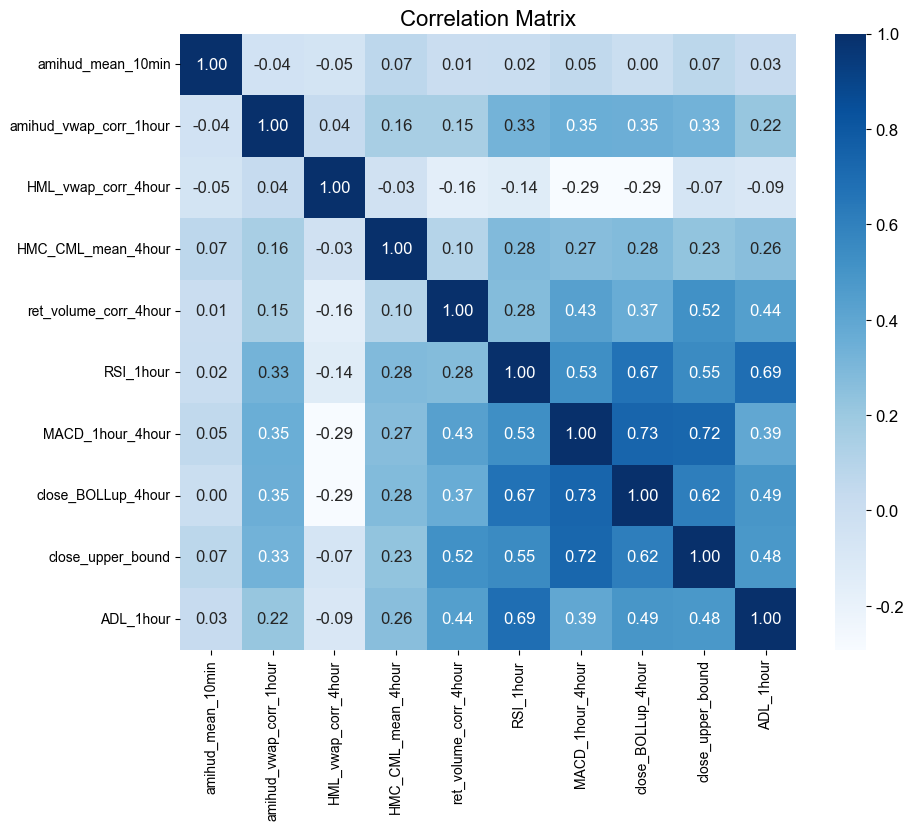

In [10]:
# 假设 factors 和 final_factor_list 已经定义
for FundCode in ['F588080','F159915']:
    corr_matrix = factors[FundCode][final_factor_list].corr()

    # 创建热力图
    plt.figure(figsize=(10, 8))  # 设置图形的大小

    # 调整字体设置
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 12

    # 绘制热力图
    heatmap = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='Blues', square=True,
                        linewidths=0, linecolor='gray')

    # 设置标题
    plt.title('Correlation Matrix', fontsize=16)

    # 调整刻度标签的大小
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # 保存图像为高 PPI 的文件
    plt.savefig(f'output/factor_correlation_heatmap_{FundCode}.png', dpi=300)

    # 显示图形
    plt.show()

### 3.3 查看机器学习因子的表现

In [66]:
from main import *


In [103]:
## 分别读取科创50ETF和创业板ETF的分钟频数据

with open(f'configs/train.yaml', 'r') as file:
    args = DictToObj(yaml.safe_load(file))
ETF_minquotes = pd.read_parquet('ETF_minquotes.parquet')
F588080 = ETF_minquotes.loc[ETF_minquotes['windcode'] == '588080.SH']
F159915 = ETF_minquotes.loc[ETF_minquotes['windcode'] == '159915.SZ']
F588080.loc[:,'htc_ret'] = F588080.groupby(F588080.index.date).apply(lambda x:x['close'].iloc[-1]/x['open'].shift(-1)-1).values
F159915.loc[:,'htc_ret'] = F159915.groupby(F159915.index.date).apply(lambda x:x['close'].iloc[-1]/x['open'].shift(-1)-1).values
F588080_Test = F588080.loc[(F588080.index.date >= args.TEST.START_DATE) & (F588080.index.date <= args.TEST.END_DATE)]
F159915_Test = F159915.loc[(F159915.index.date >= args.TEST.START_DATE) & (F159915.index.date <= args.TEST.END_DATE)]


In [104]:
class ModelPred():
    def __init__(self, 
                 localpath = '.'):
        self.localpath = localpath
        with open(f'{self.localpath}/configs/train.yaml', 'r') as file:
            self.args = DictToObj(yaml.safe_load(file))
        set_seed(self.args.SEED)

    def load_model_and_final_map(self,tr,fc): # tr:TrainYear fc:FundCode
        """加载模型"""
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = ALSTM(input_size = len(self.args.FACTOR_LIST)+1,
                    embedding_dim = self.args.EMBEDDING_DIM, 
                    hidden_size = self.args.HIDDEN_SIZE, 
                    query_size = self.args.QUERY_SIZE, 
                    num_layers = self.args.NUM_LAYERS)
        final_map = nn.Sequential(
            nn.Linear(2 * self.args.HIDDEN_SIZE, 1, bias=True),
            nn.Sigmoid()
            )
        check_point = torch.load(f'{self.localpath}/models/model_{tr}_{fc}.pth')
        model.load_state_dict(check_point['model'])
        model.to(device)
        model.eval()
        final_map.load_state_dict(check_point['final_map'])
        final_map.to(device)
        final_map.eval()
        return model, final_map

    def model_pred(self, FundCode):
        with open(f'{self.localpath}/data/Test_data_{FundCode}.pickle', 'rb') as file:
            Test_data = pickle.load(file)
        with open(f'{self.localpath}/data/Test_label_{FundCode}.pickle', 'rb') as file:
            Test_label = pickle.load(file)
            
        Test_label.index = Test_label['time']
        Test_label_2022 = Test_label.loc[Test_label.index.date <= self.args.TRAIN2023.END_DATE]
        Test_label_2023 = Test_label.loc[Test_label.index.date > self.args.TRAIN2023.END_DATE]
        Test_data_2022 = Test_data[:(len(Test_label_2022))]
        Test_data_2023 = Test_data[(len(Test_label_2022)):]
        TestDataloader_2022 = DataLoader(MyDataset(Test_data_2022, Test_label_2022['htc_ret'].values), batch_size = self.args.BATCH_SIZE, shuffle=False)
        TestDataloader_2023 = DataLoader(MyDataset(Test_data_2023, Test_label_2023['htc_ret'].values), batch_size = self.args.BATCH_SIZE, shuffle=False)
        result = []
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        for tr, TestDataloader_y in zip([2022,2023],[TestDataloader_2022, TestDataloader_2023]):
            model, final_map = self.load_model_and_final_map(tr, FundCode)
            for inputs, labels in tqdm(TestDataloader_y):
                inputs = inputs.float().to(device)
                labels = labels.float().to(device)
                with torch.no_grad():  # 关闭梯度计算
                    output = final_map(model(inputs))
                result += output.cpu().detach().numpy().flatten().tolist()
        Test_label['pred_htc_ret'] = result
        return Test_label

In [115]:
ModelPred_ = ModelPred()
Test_pred_F588080 = ModelPred_.model_pred('F588080')
Test_pred_F159915 = ModelPred_.model_pred('F159915')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15588\160445543.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(f'{self.localpath}/models/m

IC1为 0.160,IR1为 2.232
IC2为 0.164,IR2为 5.859


<Axes: xlabel='time'>

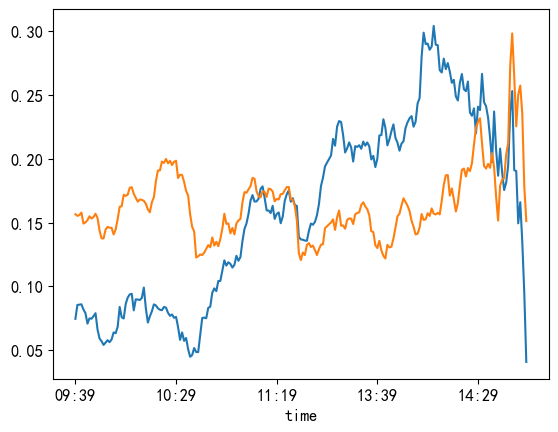

In [116]:
IC1 = Test_pred_F588080.groupby([Test_pred_F588080.index.strftime("%H:%M")]).apply(lambda x:x['htc_ret'].corr(x['pred_htc_ret']))
IC2 = Test_pred_F159915.groupby([Test_pred_F159915.index.strftime("%H:%M")]).apply(lambda x:x['htc_ret'].corr(x['pred_htc_ret']))
print(f'IC1为{IC1.mean(): .3f},IR1为{IC1.mean()/IC1.std(): .3f}')
print(f'IC2为{IC2.mean(): .3f},IR2为{IC2.mean()/IC2.std(): .3f}')
IC1.plot()
IC2.plot()

In [92]:
F588080_Test.loc[:,'pred'] = Test_pred_F588080.groupby(Test_pred_F588080.index.strftime('%H:%M')).apply(lambda x: x['pred_htc_ret'].rolling(20,min_periods=5).rank(pct=True)).droplevel(0)

平均持仓时间: 81.87 分钟
平均每日交易次数: 0.98
胜率：0.46
平均单次盈利: 0.008
平均单次亏损: -0.004
平均单次盈利/亏损: 1.877
年化收益率：0.427
年化波动率：0.156
年化夏普比率：2.742
最大回撤: 0.083
Calmar比率: 5.147


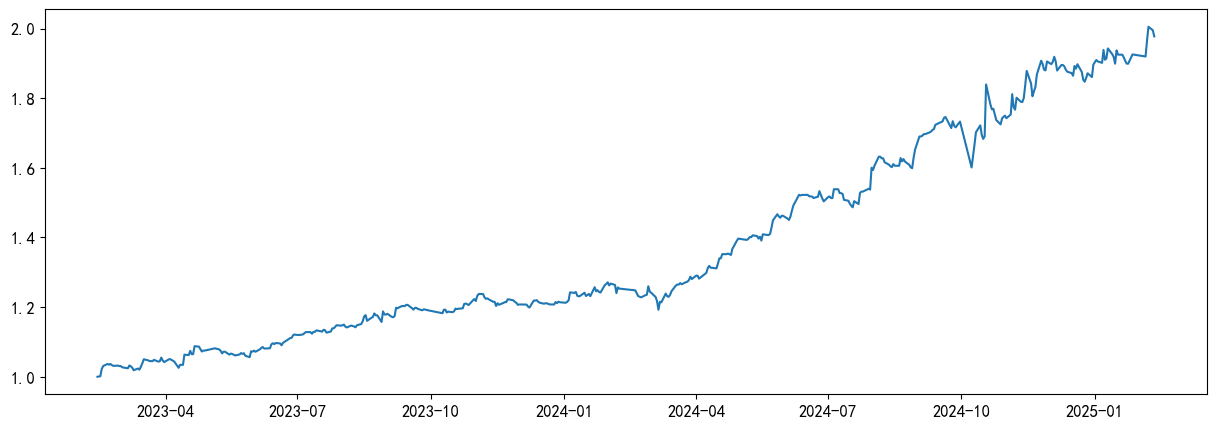

In [120]:
F588080_Test.loc[:,'pred'] = Test_pred_F588080['pred_htc_ret'].rolling(1200,min_periods=240).rank(pct=True)

start_time = '10:00'
end_time = '14:55'
upper_quantile = 0.8
lower_quantile = 0.2
upper_stop_quantile = 0.6
lower_stop_quantile = 0.4
FinalFactorIC = F588080_Test.groupby(F588080_Test.index.strftime('%H:%M')).apply(lambda x: x['pred'].rolling(120,min_periods=60).corr(x['htc_ret']).shift()).droplevel(0).sort_index()
FinalFactorIC = FinalFactorIC.apply(lambda x: 0 if x<0 else x).fillna(0)
FinalFactorIC.loc[(FinalFactorIC.index.strftime('%H:%M')<start_time)|(FinalFactorIC.index.strftime('%H:%M')>end_time)] = 0
upper_bound = FinalFactorIC.groupby(FinalFactorIC.index.date).transform(lambda x: upper_quantile-0.2*x/x.sum())
lower_bound = FinalFactorIC.groupby(FinalFactorIC.index.date).transform(lambda x: lower_quantile+0.2*x/x.sum())

strategy = ETFIntradayStrategy(
    data = F588080_Test,
    factor_name = 'pred',
    direction = 1,
    start_date = '2023-02-12',
    end_date = '2025-02-11',
    periods = [('09:44','14:54')],
    rolling_is_rank = True,
    rolling_window = 1200,
    bound_is_series = True,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.6,
    lower_stop_bound = 0.4,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

平均持仓时间: 128.71 分钟
平均每日交易次数: 0.96
胜率：0.53
平均单次盈利: 0.009
平均单次亏损: -0.005
平均单次盈利/亏损: 1.712
年化收益率：0.672
年化波动率：0.168
年化夏普比率：3.995
最大回撤: 0.115
Calmar比率: 5.862


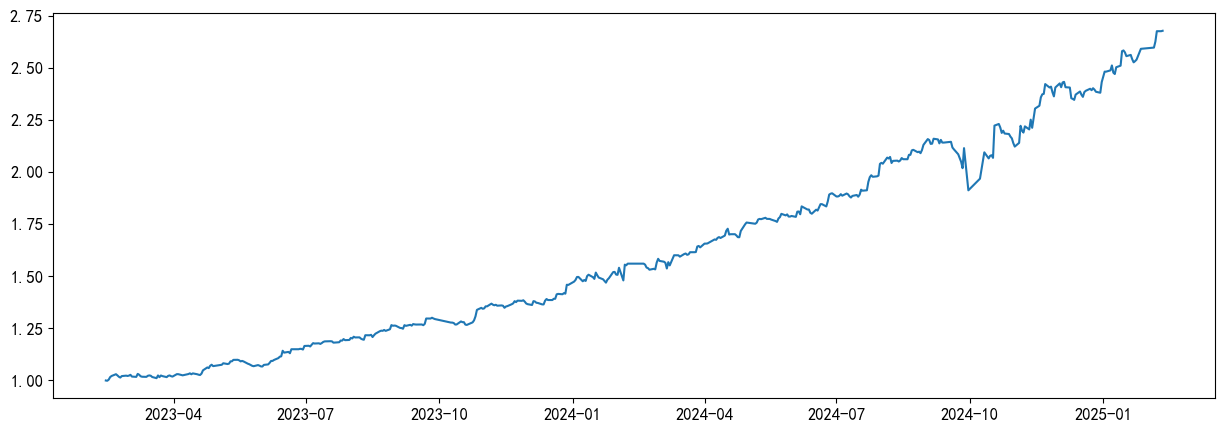

In [119]:
F159915_Test['pred'] = Test_pred_F159915['pred_htc_ret'].rolling(1200,min_periods=240).rank(pct=True)
#F159915_Test.loc[:,'pred'] = Test_pred_F159915.groupby(Test_pred_F159915.index.strftime('%H:%M')).apply(lambda x: x['pred_htc_ret'].rolling(20,min_periods=5).rank(pct=True)).droplevel(0)
#F159915_Test.loc[:,'pred'] = F159915_Test.loc[:,'pred'].rolling(5,min_periods=2).mean()
start_time = '10:00'
end_time = '14:55'
upper_quantile = 0.8
lower_quantile = 0.2
upper_stop_quantile = 0.6
lower_stop_quantile = 0.4
FinalFactorIC = F159915_Test.groupby(F159915_Test.index.strftime('%H:%M')).apply(lambda x: x['pred'].rolling(120,min_periods=60).corr(x['htc_ret']).shift()).droplevel(0).sort_index()
FinalFactorIC = FinalFactorIC.apply(lambda x: 0 if x<0 else x).fillna(0)
FinalFactorIC.loc[(FinalFactorIC.index.strftime('%H:%M')<start_time)|(FinalFactorIC.index.strftime('%H:%M')>end_time)] = 0
upper_bound = FinalFactorIC.groupby(FinalFactorIC.index.date).transform(lambda x: upper_quantile-0.2*x/x.sum())
lower_bound = FinalFactorIC.groupby(FinalFactorIC.index.date).transform(lambda x: lower_quantile+0.2*x/x.sum())

#upper_bound = F159915_Test.groupby(F159915_Test.index.date).transform(lambda x: upper_quantile-0.2*x/x.sum())
#lower_bound = F159915_Test.groupby(F159915_Test.index.date).transform(lambda x: lower_quantile+0.2*x/x.sum())

strategy = ETFIntradayStrategy(
    data = F159915_Test,
    factor_name = 'pred',
    direction = 1,
    start_date = '2023-02-12',
    end_date = '2025-02-11',
    periods = [('09:44','14:54')],
    rolling_is_rank = True,
    rolling_window = 1200,
    bound_is_series = True,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.4,
    lower_stop_bound = 0.6,
    stop_loss_ratio = 0.02
)

daily_performance = strategy.get_performance()

## 四、日内动量策略
目前还差一个止损条件

In [1]:
from main import *
ETF_minquotes = pd.read_parquet(f'ETF_minquotes.parquet')
F588080 = ETF_minquotes.loc[ETF_minquotes['windcode'] == '588080.SH']
F159915 = ETF_minquotes.loc[ETF_minquotes['windcode'] == '159915.SZ']

def GetMomBound(minquote):
    """计算动量策略的上下限"""
    minquote.loc[:,'open0930'] = minquote.groupby(minquote.index.date)['open'].transform(lambda x: x.iloc[0])  # 0930开盘价
    minquote.loc[:,'move'] = (minquote['close']/minquote['open0930']-1).abs()  # 计算每分钟的价格位移
    minquote.loc[:,'move_rolling10'] = minquote.groupby(minquote.index.strftime('%H:%M'))['move'].transform(lambda x: x.rolling(10,min_periods=5).mean())
    minquote.loc[:,'close_last'] = (minquote.groupby(minquote.index.date)['close'].transform(lambda x: x.iloc[-1])).shift(240)  # 前一日收盘价
    minquote.loc[:,'upper_bound'] = minquote[['open0930','close_last']].max(axis=1)*(1+minquote['move_rolling10'])  # 计算上限
    minquote.loc[:,'lower_bound'] = minquote[['open0930','close_last']].min(axis=1)*(1-minquote['move_rolling10'])  # 计算下限
    return minquote

F159915 = GetMomBound(F159915)
F588080 = GetMomBound(F588080)

平均持仓时间: 161.09 分钟
平均每日交易次数: 0.85
胜率：0.58
平均单次盈利: 0.010
平均单次亏损: -0.008
平均单次盈利/亏损: 1.310
年化收益率：0.745
年化波动率：0.175
年化夏普比率：4.259
最大回撤: 0.065
Calmar比率: 11.389


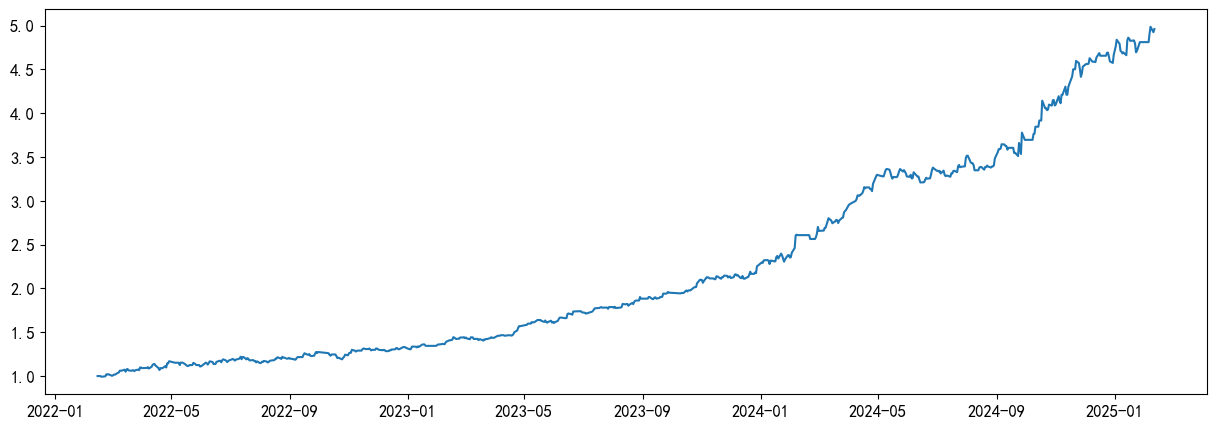

In [7]:
strategy = ETFIntradayStrategy(
    data=F159915,
    factor_name = 'close',
    direction = 1,
    start_date='2022-02-14',
    periods = [('09:30','15:00')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = True,
    upper_bound = F159915['upper_bound'],
    lower_bound = F159915['lower_bound'],
    upper_stop_bound = F159915['lower_bound'],
    lower_stop_bound = F159915['upper_bound'],
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()
daily_performance.to_excel('output/CTA_dailyret_159915.xlsx')

平均持仓时间: 163.20 分钟
平均每日交易次数: 0.88
胜率：0.52
平均单次盈利: 0.011
平均单次亏损: -0.009
平均单次盈利/亏损: 1.202
年化收益率：0.296
年化波动率：0.198
年化夏普比率：1.496
最大回撤: 0.133
Calmar比率: 2.234


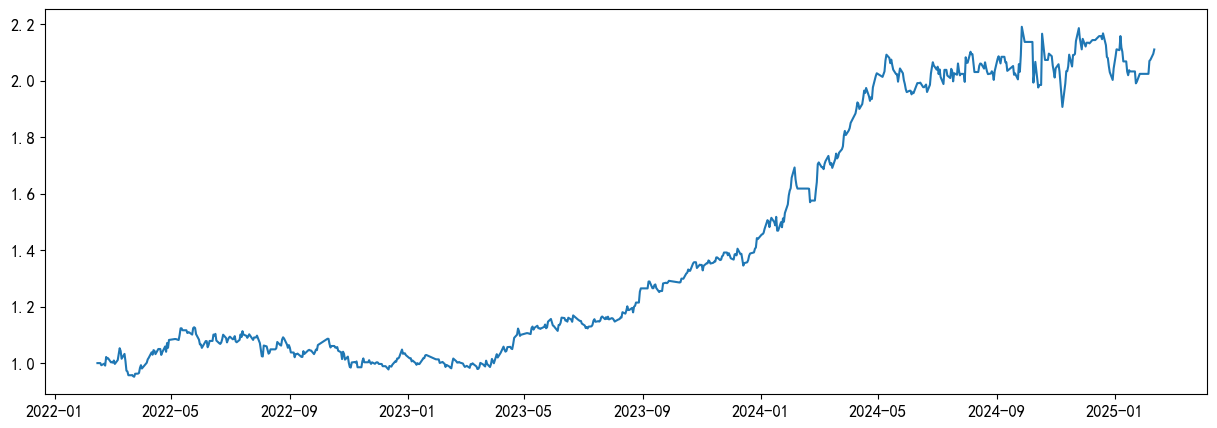

In [10]:
strategy = ETFIntradayStrategy(
    data=F588080,
    factor_name = 'close',
    direction = 1,
    start_date='2022-02-14',
    periods = [('09:30','15:00')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = True,
    upper_bound = F588080['upper_bound'],
    lower_bound = F588080['lower_bound'],
    upper_stop_bound = F588080['lower_bound'],
    lower_stop_bound = F588080['upper_bound'],
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()
daily_performance.to_excel('output/CTA_dailyret_588080.xlsx')

### 4.1 具体交易日画图

In [5]:
daily_performance

direction  holdingmins  dailyret
2023-02-14         -1          170 -0.003989
2023-02-15         -1          239 -0.002165
2023-02-16         -1          216  0.020259
2023-02-17         -1          227  0.014624
2023-02-20         -1           25 -0.008992
...               ...          ...       ...
2025-02-05          0            0 -0.000100
2025-02-06          1          223  0.022647
2025-02-07          1          224  0.001821
2025-02-10          1          236  0.010375
2025-02-11         -1          239  0.007256

[482 rows x 3 columns]

In [9]:
F159915_temp1 = F159915.loc[F159915.index.date == pd.to_datetime('2024-06-25').date()]
F159915_temp2 = F159915.loc[F159915.index.date == pd.to_datetime('2024-10-18').date()]
F159915_temp1.to_excel('output/F159915_temp1.xlsx')
F159915_temp2.to_excel('output/F159915_temp2.xlsx')